In [1]:
%%configure -f
{ "conf":{
          "spark.pyspark.python": "python3",
          "spark.pyspark.virtualenv.enabled": "true",
          "spark.pyspark.virtualenv.type":"native",
          "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv",
          "spark.sql.execution.arrow.enabled":"true"
         }
}

[I 2023-03-02 00:32:12,502.502 configure_magic] Magic cell payload received: {"conf": {"spark.pyspark.python": "python3", "spark.pyspark.virtualenv.enabled": "true", "spark.pyspark.virtualenv.type": "native", "spark.pyspark.virtualenv.bin.path": "/usr/bin/virtualenv", "spark.sql.execution.arrow.enabled": "true"}, "proxyUser": "assumed-role_fdp_blitvin-Isengard"}

[I 2023-03-02 00:32:12,503.503 configure_magic] Sending request to update kernel. Please wait while the kernel will be refreshed.


The kernel is successfully refreshed.

In [1]:
import pyEX as p
import requests
import json
import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt
import itertools
import datetime
#import awswrangler as wr
import vectorbt as vbt
import pyspark.sql.functions as py_f
import pyspark.sql.types as py_t
import pyspark.sql.window as py_w
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.requests import StockBarsRequest
import pyarrow as pa
import pyarrow.parquet as pq
import boto3
from botocore.exceptions import ClientError
import pyfolio as pf
import scipy.stats as stats
from numba import jit

isSandbox = False
if isSandbox:
    token = 'Tpk_02dcd2036e7641b880dd4cbb01fa9c67'
    iex_ver = 'sandbox'
else:
    #token ='pk_2e94555e43da4135a6032433c6b18fa5'
    token = 'pk_79d147436c1349f3abbec37591323e52'
    iex_ver = 'stable'
pyEX_cl = p.Client(api_token=token)
timeframe = 'max'

/usr/local/lib/python3.7/site-packages/tzlocal/unix.py:177: UserWarning: Can not find any timezone configuration, defaulting to UTC.
  warnings.warn("Can not find any timezone configuration, defaulting to UTC.")
/usr/local/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [2]:
ALPACA_API_KEY_ID = 'AK8MWGDK1GMSP91W1SGM'
ALPACA_API_SECRET_KEY = 'oM5h4WWGfuKrctHWdCmtpwLcOuoV5TLemJ5ImavI'
etf_parquet_file = 's3://fsidatalake/intraday_market_data/etf_30mins.parquet'


In [3]:
if False:
    fx_etf_symbols = [
        'FXA',
        'FXY',
        'FXE',
        'FXB',
        'UUP',
        'FXC',
        'FXF',
    ]
    bitcoin_etf_symbols = ['BITO']
    commod_etf_symbols = [
        'USO',
        'GLD',
        'DBA',
        'DBB',
        'SLV',
    ]
    fi_etf_symbols = [
        'IAGG',
        'AGG',
        'IHY',
        'EMLC',
        'HYG',
    ]
    equity_etf_symbols = [
        'AMJ', 'AMLP', 'ARKF', 'ARKG', 'ARKK', 'ARKQ', 'ARKW', 'BOTZ', 'BUG',
        'CGW', 'CIBR', 'COPX', 'CRBN', 'DRIV', 'EFV', 'EMLP', 'FBT', 'FDN',
        'FIVG', 'FIW', 'FTXG', 'GDX', 'GNR', 'GUNR', 'HACK', 'IAT', 'IBB',
        'ICLN', 'IEO', 'IFRA', 'IGE', 'IGF', 'IGM', 'IGV', 'IHF', 'IHI', 'ITB',
        'ITZ', 'IWD', 'IWN', 'IWS', 'IYT', 'JETS', 'KBWB', 'KOMP', 'KRE',
        'KWEB', 'LCTU', 'LIT', 'MLPA', 'MLPX', 'MOO', 'NFRA', 'OIH', 'PABU',
        'PAVE', 'PBW', 'PEJ', 'PHO', 'PICK', 'PPA', 'QCLN', 'REET', 'REMX',
        'ROBO', 'SCHH', 'SIL', 'SKYY', 'SMH', 'SOXX', 'SRVR', 'TAN', 'URA',
        'URNM', 'VUG', 'XAR', 'XBI', 'XHB', 'XME', 'XOP', 'XSD', 'QQQ', 'EWZ',
        'AAXJ', 'VTI', 'EWJ', 'EWA', 'EWC', 'MCHI', 'EWU', 'EWQ', 'EWG', 'FM',
        'EIS'
    ]
    sectors = [
        'XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK',
        'XLU'
    ]
    bench_symbol = ['SPY', 'QQQ', 'IVV']
    all_symbols = fx_etf_symbols + bitcoin_etf_symbols + commod_etf_symbols + fi_etf_symbols + equity_etf_symbols + bench_symbol + sectors
    #all_symbols
    columns_to_capture = ['close', 'open', 'symbol']
    data_folder = 's3://fsidatalake/eod_market_data/etf_trend_following/'
    parquet_file_out = f"{data_folder}/etf_market_data.parquet"

In [4]:
#import boto3
#dynamodb = boto3.resource('dynamodb')
#financial_indexes = dynamodb.Table('financial_indexes')
#financial_indexes.get_item(Key={"symbol":{"S":"SPY"}})
#syms=pd.DataFrame([{'symbol':'SPY'}])
#ret_df= get_new_data_df(syms)
#ret_df

region_name='us-east-2'
secret_name = 'alpaca_marketdata_key'
session = boto3.session.Session()
client = session.client(
    service_name='secretsmanager',
    region_name=region_name
)

try:
    get_secret_value_response = client.get_secret_value(
        SecretId=secret_name
    )
except ClientError as e:
    # For a list of exceptions thrown, see
    # https://docs.aws.amazon.com/secretsmanager/latest/apireference/API_GetSecretValue.html
    raise e

# Decrypts secret using the associated KMS key.
secret = json.loads(get_secret_value_response['SecretString'])[secret_name]
secret

'AK8MWGDK1GMSP91W1SGM'

In [5]:
def get_data_plot_spread(t1, t2):
    goog_full_pd = get_new_data_df_alpaca([t1], start_date="2000-01-02")
    googl_full_pd = get_new_data_df_alpaca([t2], start_date="2000-01-02")
    goog_spread_pd = googl_full_pd.set_index('timestamp').join(
        goog_full_pd.set_index('timestamp'), lsuffix='_t1',
        rsuffix='_t2').dropna()
    goog_spread_pd['close_spread'] = goog_spread_pd['close_t1'].pct_change(
    ) - goog_spread_pd['close_t2'].pct_change()
    goog_spread_pd['close_spread'].rolling(8).sum().plot()
    return (goog_spread_pd)




In [6]:
timeframe=30
def get_emtpy_df(l_exc,symbols):
        return(pd.DataFrame([{
            'symbol':f'",".join(symbols):{l_exc}',
            'timestamp_utc':None,
            'open':None,
            'high':None,
            'low':None,
            'close':None,
            'volume':None,
            'trade_count':None,
            'vwap':None,
            'date':None,
            'minute':None,
        }]))
def get_alpaca_data(start_date,end_date,symbols,tf):
        ALPACA_API_KEY_ID = 'AK8MWGDK1GMSP91W1SGM'
        ALPACA_API_SECRET_KEY = 'oM5h4WWGfuKrctHWdCmtpwLcOuoV5TLemJ5ImavI'
        data_client = StockHistoricalDataClient(ALPACA_API_KEY_ID,
                                                ALPACA_API_SECRET_KEY)
        timeframe_30_min = TimeFrame(tf, TimeFrameUnit.Minute)

        request_parameters = StockBarsRequest(
            symbol_or_symbols=symbols,
            timeframe=timeframe_30_min,
            start=start_date,
            end=end_date,
        )

        # Fetch data and convert to dataframe
        min_30_bars = data_client.get_stock_bars(
            request_parameters).df.reset_index()
        min_30_bars['date'] = min_30_bars.timestamp.dt.date
        min_30_bars['minute'] = (min_30_bars.timestamp.dt.hour.astype(str).str.pad(
            2, fillchar='0')) + ":" + (min_30_bars.timestamp.dt.minute.astype(
                str).str.pad(2, fillchar='0'))
        min_30_bars=min_30_bars.rename(columns={'timestamp':'timestamp_utc'})
        return(min_30_bars)
def get_new_data_df_alpaca(symbol,tf):
    ret_columns= ['symbol' ,'timestamp_utc' ,'open' ,'high'  \
    ,'low' ,'close' ,'volume' ,'trade_count' ,'vwap' ,'date' ,'minute' ]
    try:
        start_date = "2000-01-02"
        end_date = "2023-02-06"
        if type(symbol) == pd.core.frame.DataFrame:
            symbols = [i for i in symbol.symbol.values]
        else:
            local_syms = str(symbol.values[0][0])
            symbols = [local_syms]


        # Set parameters

        start_date = pd.to_datetime(start_date).tz_localize('America/New_York')
        end_date = pd.to_datetime(end_date).tz_localize('America/New_York')

        min_30_bars=get_alpaca_data(start_date,end_date,symbols,tf)
    except Exception as l_exc:
        print(f'exception{str(l_exc)} for {",".join(symbols)}')
        if l_exc.code==42210000:
            try:
                rejected_symbols = [i.replace(' ','') for i in json.loads(l_exc.args[0])['message'].split(':')[1].split(',')]
                clean_symbols = [i for i in symbols if i not in rejected_symbols]
                min_30_bars=get_alpaca_data(start_date,end_date,clean_symbols)
            except Exception as L_exc_1:
                min_30_bars=get_empty_df()
        else:
            min_30_bars=get_emtpy_df(l_exc,symbols)
    return (min_30_bars)


sym_list = [
    'XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK',
    'XLU', 'SPY', 'QQQ', 'VTI', 'VTV', 'BND', 'AGG', 'VUG', 'VIG', 'IJR', 'IJH',
    'IEMG', 'IWF', 'IWD', 'GLD', 'IWM', 'VYM', 'VXUS', 'VO', 'EFA', 'SCHD',
    'ARKK'
]
if False:
    etf_pd = get_new_data_df_alpaca(sym_list,timeframe)
if False:
    #syms=pd.DataFrame([{'symbol':'XLC'}])
    #etf_pd = get_new_data_df_alpaca(syms)
    panda_udf_schema = "symbol string,timestamp_utc timestamp,open double,high double \
    ,low double,close double,volume double,trade_count double,vwap double,date date,minute string"
    
    new_sym_df=mdg.all_symbols_df.where(py_f.col('symbol').isin(['ARKK','SPY','QQQ'])).distinct().groupby("shard_id")\
                            .applyInPandas(lambda x: get_new_data_df_alpaca(x,timeframe), schema=panda_udf_schema )\
                            #.where('close is not null')
    #print(new_sym_df.count())
    new_sym_df.write\
                .option("header",True)\
                .partitionBy('symbol')\
                .mode("overwrite")\
                .parquet(mdg.parquet_file_out)
    


In [7]:
mdg.all_symbols_df.where(py_f.col('symbol').isin(['ARKK','SPY','QQQ'])).distinct().show()
#md_30m_df = spark.read.parquet(mdg.parquet_file_out)
#md_30m_df.show(truncate=False)
#get_new_data_df_alpaca(['SPY'])

NameError: name 'mdg' is not defined

In [8]:
etf_df = spark.createDataFrame(etf_pd.reset_index())
etf_df.write\
            .option("header",True)\
            .partitionBy('symbol')\
            .mode("overwrite")\
            .parquet(etf_parquet_file)

NameError: name 'etf_pd' is not defined

In [9]:
#@py_f.pandas_udf("date timestamp, close double, open double, symbol string", py_f.PandasUDFType.GROUPED_MAP)
#@py_f.pandas_udf("symbol string", py_f.PandasUDFType.GROUPED_MAP)
#syms=pd.DataFrame([{'symbol':'SPY'}])
#get_new_data_df(syms)
def get_new_data_df(symbol):
    local_sym = str(symbol.values[0][0])
    try:
        hwm_l = highwatermark_pd_bc.value
        columns_to_capture = columns_to_capture_bc.value
        iex_base_url = iex_base_url_bc.value
        sym_pd = hwm_l.query(f"symbol=='{local_sym}'")
        if len(sym_pd) > 0:
            max_date = sym_pd['max_date'].iloc[0]
        else:
            max_date = datetime.datetime.now() - datetime.timedelta(days=365 *
                                                                    50)
        last_days = (datetime.datetime.now() - max_date).days

        pyEX_cl = p.Client(api_token=iex_token_bc.value)
        final_url = iex_base_url.format(local_sym, iex_token_bc.value,
                                        int(last_days))
        #'https://cloud.iexapis.com/stable/stock/{}/chart/max?token={}&chartIEXOnly=true&chartLast={}'
        print(final_url)
        res = requests.get(final_url)
        ret_pd = pd.DataFrame(json.loads(res.text))  #[columns_to_capture]
        ret_pd = ret_pd.query(f"date>'{max_date.strftime('%Y-%m-%d')}'")
        ret_pd['date'] = pd.to_datetime(ret_pd['date'])
        ret_pd['symbol'] = local_sym
        for one_col in ['open', 'high', 'low', 'close']:
            ret_pd[f'market{one_col.capitalize()}'] = np.where(
                ret_pd[f'market{one_col.capitalize()}'].isnull(),
                ret_pd[one_col], ret_pd[f'market{one_col.capitalize()}'])
            ret_pd[one_col] = np.where(ret_pd[one_col].isnull(),
                                       ret_pd[f'market{one_col.capitalize()}'],
                                       ret_pd[one_col])
        #return(ret_pd[columns_to_capture].query(f"date>'{max_date}'"))
    except:
        ret_pd = pd.DataFrame([{
            'date': datetime.datetime.now() - datetime.timedelta(days=365 * 50),
            'minute': None,
            'open': None,
            'high': None,
            'low': None,
            'close': None,
            'notional': None,
            'numberOfTrades': None,
            'symbol': local_sym,
            'marketOpen': None,
            'marketHigh': None,
            'marketLow': None,
            'marketClose': None,
            'marketNotional': None,
            'marketNumberOfTrades': None
        }])
    #return(ret_pd[columns_to_capture],max_date,hwm_l,local_sym,sym_pd)
    return (ret_pd[columns_to_capture])
    #return(pd.DataFrame([res.text],columns=['symbol']))

In [10]:
refresh_data = False

class MarketDataGateway():
    def __init__(self, tf,isSandbox=False,shard_size=20):
        self.shard_size=shard_size
        self.fx_etf_symbols = [
            'FXA',
            'FXY',
            'FXE',
            'FXB',
            'UUP',
            'FXC',
            'FXF',
        ]
        self.bitcoin_etf_symbols = [
            'BITO', 'BTF', 'XBTF', 'BITS', 'GBTC', 'BITW', 'BLOK', 'BLCN',
            'LEGR', 'SPBC', 'BITQ', 'BKCH', 'DAPP', 'BTCFX'
        ]
        self.bitcoin_equity_proxy_symbols = ['COIN', 'MSTR']
        self.crypto_mining_symbols = [
            'RIOT', 'CAN', 'HUT', 'HIVE', 'MARA', 'BTCM', 'BTBT', 'BITF'
        ]
        self.commod_etf_symbols = [
            'USO',
            'GLD',
            'DBA',
            'DBB',
            'SLV',
        ]
        self.fi_etf_symbols = [
            'IAGG',
            'AGG',
            'IHY',
            'EMLC',
            'HYG',
        ]
        self.equity_share_class_pairs = ['GOOG','GOOGL',
'AMC','APE',
'BRK.A','BRK.B',
'CWEN','CWEN.A',
'CRD.A','CRD.B',
'FCNCA','FCNCO',
'F','F/PC',
'GTN','GTN.A',
'GEF','GEF.B',
'GR3','GB6B',
'HLAH','HLAHU',
'HEI','HEI.A',
'WLY','WLYB',
'2F7','2F70',
'KELYA','KELYB',
'LEN','LEN.B',
'LBRDK','LBRDA',
'8L8C','8L8',
'QRTEA','QRTEB',
'LSXMA','LSXMK',
'FWONA','FWONK',
'BATRA','BATRK',
'LTRPA','LTRPB',
'MKC','MKC.V',
'MKC','MKCV',
'MSTR','MSTRD',
'TAP','TAP.A',
'TPX.A','TPX.B',
'MOG.A','MOG.B',
'MO7A','MO7R',
'NWS','NWSA',
'PICC','PICC.U',
'RDI','RDIB',
'RUSHA','RUSHB',
'SENEA','SENEB',
'MSGE','MSGS',
'T2E','4T0',
'FOX','FOXA',
'UA','UAA',
'UBA','UBP',
'0VV','0VVB',
'WSO','WSO.B',
        ]
        self.equity_etf_symbols = [
            'AMJ', 'AMLP', 'ARKF', 'ARKG', 'ARKK', 'ARKQ', 'ARKW', 'BOTZ',
            'BUG', 'CGW', 'CIBR', 'COPX', 'CRBN', 'DRIV', 'EFV', 'EMLP', 'FBT',
            'FDN', 'FIVG', 'FIW', 'FTXG', 'GDX', 'GNR', 'GUNR', 'HACK', 'IAT',
            'IBB', 'ICLN', 'IEO', 'IFRA', 'IGE', 'IGF', 'IGM', 'IGV', 'IHF',
            'IHI', 'ITB', 'ITZ', 'IWD', 'IWN', 'IWS', 'IYT', 'JETS', 'KBWB',
            'KOMP', 'KRE', 'KWEB', 'LCTU', 'LIT', 'MLPA', 'MLPX', 'MOO', 'NFRA',
            'OIH', 'PABU', 'PAVE', 'PBW', 'PEJ', 'PHO', 'PICK', 'PPA', 'QCLN',
            'REET', 'REMX', 'ROBO', 'SCHH', 'SIL', 'SKYY', 'SMH', 'SOXX',
            'SRVR', 'TAN', 'URA', 'URNM', 'VUG', 'XAR', 'XBI', 'XHB', 'XME',
            'XOP', 'XSD', 'QQQ', 'EWZ', 'AAXJ', 'VTI', 'EWJ', 'EWA', 'EWC',
            'MCHI', 'EWU', 'EWQ', 'EWG', 'FM', 'EIS'
        ]
        self.sectors = [
            'XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE',
            'XLK', 'XLU'
        ]
        self.sp500 = [
            "AAPL", "MSFT", "AMZN", "GOOGL", "BRK.B", "GOOG", "NVDA", "TSLA",
            "XOM", "UNH", "JNJ", "JPM", "V", "META", "PG", "HD", "CVX", "MA",
            "LLY", "MRK", "ABBV", "BAC", "PFE", "AVGO", "KO", "PEP", "TMO",
            "COST", "WMT", "DIS", "MCD", "CSCO", "ABT", "WFC", "ACN", "DHR",
            "ADBE", "CMCSA", "VZ", "CRM", "PM", "NKE", "NFLX", "LIN", "TXN",
            "COP", "BMY", "NEE", "QCOM", "RTX", "T", "HON", "CAT", "ORCL",
            "AMGN", "UPS", "MS", "LOW", "SBUX", "UNP", "SPGI", "IBM", "AMD",
            "GS", "PLD", "INTU", "BA", "ELV", "INTC", "CVS", "DE", "BLK",
            "SCHW", "MDT", "LMT", "GILD", "AXP", "AMT", "C", "AMAT", "BKNG",
            "TJX", "CB", "CI", "PYPL", "NOW", "ADP", "GE", "ADI", "MDLZ",
            "TMUS", "ISRG", "MMC", "SYK", "VRTX", "SLB", "REGN", "MO", "EOG",
            "PGR", "DUK", "TGT", "ZTS", "SO", "BDX", "APD", "MU", "FISV",
            "EQIX", "AON", "LRCX", "USB", "PNC", "BSX", "TFC", "ITW", "ETN",
            "FCX", "MMM", "NOC", "CCI", "CSX", "CME", "MRNA", "EL", "MPC",
            "HUM", "ICE", "CL", "WM", "KLAC", "PXD", "NSC", "VLO", "HCA",
            "ATVI", "SNPS", "MCK", "GM", "SHW", "DG", "EMR", "F", "PSX", "D",
            "GD", "SRE", "CDNS", "MCO", "OXY", "EW", "ORLY", "MET", "AEP",
            "NXPI", "JCI", "PSA", "AIG", "MAR", "APH", "A", "GIS", "ROP", "ADM",
            "CTVA", "FDX", "ADSK", "AZO", "COF", "FIS", "TRV", "CMG", "NUE",
            "KMB", "HES", "CNC", "O", "IQV", "MCHP", "DVN", "CHTR", "MSI",
            "DOW", "NEM", "BIIB", "MSCI", "AFL", "SPG", "DXCM", "ROST", "EXC",
            "TT", "PH", "AJG", "IDXX", "LHX", "TEL", "SYY", "HLT", "MNST",
            "PCAR", "PRU", "WMB", "CTAS", "XEL", "ECL", "STZ", "AMP", "KMI",
            "HAL", "DD", "BK", "CARR", "TDG", "YUM", "PAYX", "WELL", "CMI",
            "ALL", "FTNT", "MTD", "OTIS", "EA", "CTSH", "ED", "ILMN", "STT",
            "ALB", "RMD", "AME", "ROK", "VICI", "WBD", "HSY", "DFS", "DLR",
            "KEYS", "ON", "CSGP", "DLTR", "BKR", "KHC", "GPN", "SBAC", "ANET",
            "OKE", "ODFL", "DHI", "URI", "PEG", "APTV", "PPG", "KDP", "KR",
            "WEC", "CPRT", "AWK", "IFF", "FAST", "ENPH", "CEG", "VRSK", "ES",
            "GLW", "WTW", "MTB", "CBRE", "EBAY", "FANG", "EFX", "WBA", "ABC",
            "HPQ", "ZBH", "EIX", "ULTA", "IT", "TROW", "CDW", "PCG", "GWW",
            "FRC", "LEN", "GEHC", "WY", "RSG", "TSCO", "AVB", "FITB", "HIG",
            "DAL", "LYB", "VMC", "ARE", "FTV", "ACGL", "GPC", "BAX", "ANSS",
            "LH", "AEE", "FE", "IR", "ETR", "RF", "DTE", "PPL", "RJF", "LUV",
            "PFG", "HBAN", "MLM", "EQR", "CFG", "PWR", "EXR", "HPE", "HOLX",
            "DOV", "STE", "NDAQ", "VTR", "VRSN", "CTRA", "CAH", "NTRS", "WAT",
            "STLD", "WST", "ALGN", "EPAM", "TDY", "LVS", "CHD", "TSN", "MPWR",
            "INVH", "MAA", "WAB", "MKC", "CNP", "XYL", "DRI", "BALL", "MRO",
            "CMS", "AMCR", "IEX", "TTWO", "FSLR", "SWKS", "AES", "BR", "EXPD",
            "SIVB", "KEY", "MOH", "OMC", "PKI", "K", "EXPE", "CAG", "ETSY",
            "BBY", "CLX", "MOS", "TRGP", "DGX", "SEDG", "COO", "CINF", "SYF",
            "FMC", "CF", "ZBRA", "TER", "SJM", "ATO", "UAL", "INCY", "FDS",
            "JBHT", "IRM", "NVR", "J", "PAYC", "AVY", "FLT", "TXT", "GRMN",
            "MTCH", "POOL", "LKQ", "APA", "HWM", "PEAK", "NTAP", "TRMB", "ESS",
            "VTRS", "PTC", "LW", "WRB", "MKTX", "EVRG", "WDC", "RCL", "IPG",
            "KIM", "AKAM", "RE", "IP", "TYL", "LNT", "STX", "MGM", "BRO",
            "JKHY", "LDOS", "GEN", "HST", "SNA", "PKG", "HRL", "NDSN", "CPT",
            "CBOE", "UDR", "DPZ", "SWK", "TECH", "CRL", "PHM", "CHRW", "BF.B",
            "EQT", "CE", "HSIC", "L", "PARA", "QRVO", "MAS", "LYV", "TFX",
            "KMX", "CZR", "NI", "CDAY", "TPR", "BWA", "GL", "WYNN", "CCL",
            "EMN", "AAL", "FOXA", "BXP", "CPB", "JNPR", "BIO", "BBWI", "REG",
            "ALLE", "VFC", "UHS", "WRK", "TAP", "CTLT", "CMA", "RHI", "AAP",
            "FFIV", "HII", "PNR", "WHR", "BEN", "ROL", "PNW", "IVZ", "FRT",
            "ZION", "XRAY", "NWSA", "SEE", "SBNY", "NRG", "AOS", "OGN", "HAS",
            "GNRC", "AIZ", "DXC", "ALK", "NCLH", "MHK", "NWL", "LNC", "RL",
            "LUMN", "FOX", "DVA", "DISH", "NWS"
        ]
        self.bench_symbol = ['SPY', 'QQQ', 'IVV']
        self.all_symbols =self.fx_etf_symbols+\
                            self.bitcoin_etf_symbols+\
                            self.commod_etf_symbols+\
                            self.bitcoin_equity_proxy_symbols+\
                            self.crypto_mining_symbols+\
                            self.fi_etf_symbols+\
                            self.equity_etf_symbols+\
                            self.bench_symbol+\
                            self.sectors+\
                            self.equity_share_class_pairs+\
                            self.sp500
        self.all_symbols_df = spark.createDataFrame(
            pd.DataFrame(self.all_symbols, columns=['symbol']))
        self.all_symbols_df = self.all_symbols_df.withColumn('shard_id',py_f.floor(py_f.row_number().over(py_w.Window.orderBy("symbol"))/self.shard_size))
        #all_symbols
        self.columns_to_capture = [
            'date', 'minute', 'open', 'high', 'low', 'close', 'notional',
            'numberOfTrades', 'symbol', 'marketOpen', 'marketHigh', 'marketLow',
            'marketClose', 'marketNotional', 'marketNumberOfTrades'
        ]
        self.type_excl_field_map = {
            'date': 'timestamp',
            'minute': 'string',
            'symbol': 'string'
        }
        self.pandas_udf_schema =[f"{i} double" for i in self.columns_to_capture if (i not in self.type_excl_field_map.keys()) ] +\
                                    [f"{i[0]} {i[1]}" for i in self.type_excl_field_map.items()]

        self.data_folder = 's3://fsidatalake/intraday_market_data/'
        self.parquet_file_out = f"{self.data_folder}OHLC_{tf}m.parquet"
        if isSandbox:
            self.iex_token = 'Tpk_02dcd2036e7641b880dd4cbb01fa9c67'
            self.iex_ver = 'sandbox'
        else:
            #self.iex_token ='pk_2e94555e43da4135a6032433c6b18fa5' pk_79d147436c1349f3abbec37591323e52
            self.iex_token = 'pk_79d147436c1349f3abbec37591323e52'
            self.iex_ver = 'stable'
        self.iex_base_url = 'https://cloud.iexapis.com/' + self.iex_ver + '/stock/{}/chart/1mm?token={}&chartIEXOnly=true'

    def set_highwatermarks(self):
        try:
            self.old_df = spark.read.parquet(self.parquet_file_out)
        except:
            #self.old_df = spark.createDataFrame(pd.DataFrame([{'symbol':'----','date':datetime.datetime.now()-datetime.timedelta(days=365*50)}]))
            self.old_pd = self.all_symbols_df.toPandas()
            self.old_pd['date'] = datetime.datetime.now() - datetime.timedelta(
                days=365 * 50)
            self.old_df = spark.createDataFrame(self.old_pd)
        self.highwatermark_pd = self.old_df.groupby('symbol').agg(
            py_f.max("date").alias("max_date"),
            py_f.min("date").alias("min_date"),
            (py_f.max("date") -
             py_f.min("date")).alias("date_length")).toPandas()

    def set_new_symbol_df(self):
        self.new_sym_df=self.all_symbols_df.groupby("symbol")\
                        .applyInPandas(get_new_data_df, schema= ','.join(self.pandas_udf_schema))\
                        .where('close is not null')

    def write_new_symbol_df(self):
        self.write_stats = self.new_sym_df.groupby('symbol').agg(
            py_f.count('symbol').alias('data_count'))
        self.new_sym_df.write\
            .option("header",True)\
            .partitionBy('symbol')\
            .mode("append")\
            .parquet(self.parquet_file_out)

    def set_sp500_constituents(self):
        pass

    def rewrite_if_dups(self):
        self.old_df_after_write = spark.read.parquet(self.parquet_file_out)
        self.dup_df = self.old_df_after_write.distinct().groupby(
            'date', 'symbol').count()
        dup_count = self.dup_df.where('count>1').count()
        if dup_count > 0:
            print(f"found:{dup_count} dups; sample:{self.dup_df.show()}")
            self.old_df_after_write.groupby('date','symbol').agg(py_f.mean('close').alias('close'),py_f.mean('open').alias('open'))\
            .write\
            .option("header",True)\
            .partitionBy('symbol')\
            .mode("overwrite")\
            .parquet(self.parquet_file_out.replace('.parquet','_temp.parquet'))
        else:
            print(f"no dups")


mdg = MarketDataGateway(30)
mdg.set_highwatermarks()
# set bc vars
highwatermark_pd_bc = sc.broadcast(mdg.highwatermark_pd)
columns_to_capture_bc = sc.broadcast(mdg.columns_to_capture)
iex_token_bc = sc.broadcast(mdg.iex_token)
iex_base_url_bc = sc.broadcast(mdg.iex_base_url)
# set bc vars
if refresh_data:
    mdg.set_new_symbol_df()
    mdg.write_new_symbol_df()
    print(mdg.write_stats.toPandas().sort_values(['symbol']))
#mdg.rewrite_if_dups()

In [11]:
mdg.parquet_file_out

's3://fsidatalake/intraday_market_data/OHLC_30m.parquet'

In [12]:
if True:
    study_df =spark.read.parquet(mdg.parquet_file_out) #spark.read.parquet('s3://fsidatalake/intraday_market_data/OHLC_30m.parquet')#mdg.parquet_file_out)
else:
    sym_sample = spark.read.parquet(etf_parquet_file)
study_df
study_config = {'first_bar':'14:30',
                'last_bar':'20:30',
                'random_check_bar':'17:00',
                'bench_symbol':'SPY'
               }

In [13]:
study_df.where("symbol=='ARKK' and date <= '2022-02-05' and minute=='20:30'").orderBy(py_f.col('date').desc()).show()
print(study_df.count())

+-------------------+-------+------+------+-----+---------+-----------+---------+----------+------+------+
|      timestamp_utc|   open|  high|   low|close|   volume|trade_count|     vwap|      date|minute|symbol|
+-------------------+-------+------+------+-----+---------+-----------+---------+----------+------+------+
|2022-02-04 20:30:00|  73.23|73.495| 72.48|72.68|3243366.0|    25262.0|72.868636|2022-02-04| 20:30|  ARKK|
|2022-02-03 20:30:00|  69.49|  69.5| 68.86|69.05|5561438.0|    45185.0|69.112562|2022-02-03| 20:30|  ARKK|
|2022-02-02 20:30:00|  73.31| 73.35| 72.89|73.11|2331778.0|    21788.0|73.102457|2022-02-02| 20:30|  ARKK|
|2022-02-01 20:30:00|  76.58| 77.18| 76.35|77.05|1511625.0|    14497.0| 76.81664|2022-02-01| 20:30|  ARKK|
|2022-01-31 20:30:00|74.0875| 75.44| 73.95|75.29|3976646.0|    31025.0|74.912635|2022-01-31| 20:30|  ARKK|
|2022-01-28 20:30:00|  67.53| 68.99|67.055|68.91|4018790.0|    33041.0|68.253955|2022-01-28| 20:30|  ARKK|
|2022-01-27 20:30:00|   66.5| 66.96|6

In [14]:
if False:
    first_last_df = study_df.where("is_first_bar==1 or is_last_bar==1 or is_random_check_bar==1")
    first_last_df=first_last_df.withColumn('bar_pct_change',py_f.col('close')/py_f.col('open')-1)
    last_win = py_w.Window.partitionBy("symbol","date").orderBy("timestamp_utc")
    first_last_df=first_last_df.withColumn('eod_price',py_f.lead(py_f.col('close'),2).over(last_win))
    first_last_df=first_last_df.withColumn('eod_pct_change',py_f.col('eod_price')/py_f.col('close')-1)
    first_last_df=first_last_df.where("eod_pct_change is not Null and bar_pct_change !=0").orderBy('symbol','timestamp_utc')
    first_last_df=first_last_df.withColumn('first_bar_dir',py_f.when(py_f.col('bar_pct_change')>0,1).otherwise(-1)).\
                                withColumn('eod_dir',py_f.when(py_f.col('eod_pct_change')>0,1).otherwise(-1)).\
                                withColumn('conf_ind',py_f.when(py_f.col('first_bar_dir')==py_f.col('eod_dir'),1).otherwise(-1)).\
                                withColumn('pnl',py_f.abs(py_f.col('eod_pct_change'))*py_f.col('conf_ind'))
    bench_first_last_df=first_last_df.where(f'is_bench==True').select('timestamp_utc','bar_pct_change','eod_pct_change').\
                                withColumnRenamed('bar_pct_change','bar_pct_change_bench').\
                                withColumnRenamed('eod_pct_change','eod_pct_change_bench')
    #######################
    first_last_df=first_last_df.join(bench_first_last_df,first_last_df.timestamp_utc==bench_first_last_df.timestamp_utc).drop(bench_first_last_df.timestamp_utc).\
                                withColumn('bar_pct_change_vs_bench',py_f.col('bar_pct_change')-py_f.col('bar_pct_change_bench')).\
                                withColumn('eod_pct_change_vs_bench',py_f.col('eod_pct_change')-py_f.col('eod_pct_change_bench')).\
                                withColumn('first_bar_dir_vs_bench',py_f.when(py_f.col('bar_pct_change_vs_bench')>0,1).otherwise(-1)).\
                                withColumn('eod_dir_vs_bench',py_f.when(py_f.col('eod_pct_change_vs_bench')>0,1).otherwise(-1)).\
                                withColumn('conf_ind_vs_bench',py_f.when(py_f.col('first_bar_dir_vs_bench')==py_f.col('eod_dir_vs_bench'),1).otherwise(-1)).\
                                withColumn('pnl_vs_bench',py_f.abs(py_f.col('eod_pct_change_vs_bench'))*py_f.col('conf_ind_vs_bench'))

In [15]:
pnl_rank_lower_bound=0.9
turnover_bound=0.1
study_df =study_df.withColumn('is_last_bar',
                    py_f.when(py_f.col('minute')==py_f.lit(study_config.get('last_bar')),1).otherwise(py_f.lit(0))).\
        withColumn('is_first_bar',
                    py_f.when(py_f.col('minute')==py_f.lit(study_config.get('first_bar')),1).otherwise(py_f.lit(0))).\
        withColumn('is_random_check_bar',
                    py_f.when(py_f.col('minute')==py_f.lit(study_config.get('random_check_bar')),1).otherwise(py_f.lit(0))).\
        withColumn('is_bench',
                    py_f.when(py_f.col('symbol')==py_f.lit(study_config.get('bench_symbol')),1).otherwise(py_f.lit(0))).\
        withColumn('pct_change',py_f.col('close')/py_f.col('open')-1).\
        withColumn('pct_change_vwap',py_f.col('vwap')/py_f.col('open')-1)


def get_specific_bar_df(l_df,filter_col,new_col_suffix,
                        rename_cols=['open','close','volume','vwap','pct_change','pct_change_vwap','timestamp_utc'],
                        drop_cols=['trade_count','low','high','is_last_bar','is_first_bar','is_random_check_bar','is_bench','minute']): 
    ret_df = l_df.where(f"{filter_col}==1").drop(*drop_cols)
    for one_col in rename_cols:
        ret_df=ret_df.withColumnRenamed(one_col,f"{one_col}_{new_col_suffix}")
    return(ret_df)
################################################
if False:
    first_bar_df = get_specific_bar_df(study_df,'is_first_bar','first').where(py_f.col(f"symbol").isin(mdg.sectors))
else:
    first_bar_df = get_specific_bar_df(study_df,'is_first_bar','first')
    
bench_first_bar_df = get_specific_bar_df(study_df.where('is_bench==True'),'is_first_bar','first_bench')
last_bar_df = get_specific_bar_df(study_df,'is_last_bar','last')
bench_last_bar_df = get_specific_bar_df(study_df.where('is_bench==True'),'is_last_bar','last_bench')

join_cols = ['date','symbol']

all_bars_df = first_bar_df.join(last_bar_df,on=join_cols)
all_bars_df=all_bars_df.withColumn('pct_change_eod',(py_f.col('close_last')/py_f.col('close_first')-1))
#bench_all_bars_df = bench_first_bar_df.join(bench_last_bar_df,on=['date'])
def add_trade_sizing(l_df,first_price_col,one_leg_size=100000):
    l_df= l_df.withColumn('first_bar_direction',((py_f.col(first_price_col)>0).cast('integer'))+((py_f.col(first_price_col)<0).cast('integer')*-1))
    pos_neg_stats=l_df.where("first_bar_direction==1").groupBy('date').agg(py_f.sum(py_f.col('close_first')).alias('notional_pos'),py_f.count('close_first').alias('count_pos')).join(
    l_df.where("first_bar_direction==-1").groupBy('date').agg(py_f.sum(py_f.col('close_first')).alias('notional_neg'),py_f.count('close_first').alias('count_neg')),on='date')
    pos_neg_stats=pos_neg_stats.withColumn('neg_leg_multi',py_f.col('notional_pos')/py_f.col('notional_neg'))
    l_df=l_df.join(pos_neg_stats,on='date')
    l_df=l_df.withColumn('neutral_multi',py_f.when(py_f.col('first_bar_direction')==-1,py_f.col('neg_leg_multi')).otherwise(py_f.col('first_bar_direction')))
    return(l_df)
first_col='pct_change_vwap_first'
all_bars_df=add_trade_sizing(all_bars_df,first_price_col=first_col)
#all_bars_df= all_bars_df.join(bench_all_bars_df,on=join_cols)
all_bars_df.orderBy('symbol',py_f.col('date').desc()).show(10,truncate=False)
if False:
    all_bars_df=all_bars_df.withColumn('pos_size',py_f.lit(100000)/(py_f.when(py_f.col('first_bar_direction')==1,py_f.col('count_pos')).otherwise(py_f.col('count_neg'))))
else:
    all_bars_df=all_bars_df.withColumn('pos_size',py_f.lit(1))
    
all_bars_df.show()


def add_pnl(l_df,col_suffix,first_price_col):
    ret_df = l_df.withColumn(f'dir_first',py_f.when(py_f.col(first_price_col)>0,1).otherwise(-1)).\
                  withColumn(f'dir_{col_suffix}',py_f.when(py_f.col(f'pct_change_{col_suffix}')>0,1).otherwise(-1)).\
                  withColumn(f'confusion_ind_{col_suffix}',py_f.when(py_f.col('dir_first')==py_f.col(f'dir_{col_suffix}'),1).otherwise(-1)).\
                  withColumn(f'pnl_{col_suffix}',py_f.abs(py_f.col(f'pct_change_{col_suffix}'))*py_f.col(f'confusion_ind_{col_suffix}')*py_f.col(f'pos_size'))
    return(ret_df)
def get_perf_stats(l_pd,col_suffix):
    comment=None
    symbol=l_pd.symbol.drop_duplicates().values[0]
    dir_first=str(l_pd.dir_first.drop_duplicates().values[0])
    try:
        l_pd = l_pd.set_index('date').sort_index()
    except Exception as l_exc:
        comment = f"exception:{l_exc} sym:{symbol}"
        print(comment)
    metrics =['Annual return',  'Annual volatility',
       'Sharpe ratio',  'Stability', 'Max drawdown']
    strat_stats = pf.timeseries.perf_stats(l_pd[f'pnl_{col_suffix}'])
    ret_dict={}
    for one_metric in metrics:
        #ret_dict[f"{one_metric.lower().replace(' ','_')}_buyhold"] = buy_hold_stats[one_metric]
        ret_dict[f"{one_metric.lower().replace(' ','_')}_strat"] = strat_stats[one_metric]
        #ret_dict[f"{one_metric.lower().replace(' ','_')}_diff"] = ret_dict[f"{one_metric.lower().replace(' ','_')}_strat"]-ret_dict[f"{one_metric.lower().replace(' ','_')}_buyhold"]
    ret_pd = pd.DataFrame([ret_dict])
    ret_pd['symbol']=symbol
    ret_pd['dir_first']=dir_first
    ret_pd['comment']=f'pnl_{col_suffix}'
    return(ret_pd)
panda_udf_schema= 'annual_return_strat double,'\
                  'annual_volatility_strat double,'\
                  'sharpe_ratio_strat double,'\
                  'stability_strat double,'\
                  'max_drawdown_strat double,'\
                  'symbol string,'\
                  'dir_first string,'\
                  'comment string'
pnl_suffix='eod'
first_last_df=add_pnl(all_bars_df,pnl_suffix,first_price_col=first_col)
rolling_win = py_w.Window.partitionBy('symbol').orderBy("timestamp_utc_first").rowsBetween(-100, 0)
first_last_df=first_last_df.withColumn('rolling_pnl',py_f.sum('pnl_eod').over(rolling_win))
first_last_df.show()
perf_stats_df=first_last_df.groupBy('symbol','dir_first').applyInPandas(lambda x: get_perf_stats(x,pnl_suffix), schema=panda_udf_schema )
perf_stats_df.show()

+----------+------+-------------------+----------+-----------+------------+----------+----------------------+----------------------+-------------------+---------+----------+-----------+----------+---------------------+----------------------+---------------------+-------------------+------------------+---------+------------------+---------+-------------------+------------------+
|date      |symbol|timestamp_utc_first|open_first|close_first|volume_first|vwap_first|pct_change_first      |pct_change_vwap_first |timestamp_utc_last |open_last|close_last|volume_last|vwap_last |pct_change_last      |pct_change_vwap_last  |pct_change_eod       |first_bar_direction|notional_pos      |count_pos|notional_neg      |count_neg|neg_leg_multi      |neutral_multi     |
+----------+------+-------------------+----------+-----------+------------+----------+----------------------+----------------------+-------------------+---------+----------+-----------+----------+---------------------+--------------------

In [16]:
rank_win = py_w.Window.partitionBy('date').orderBy("rolling_pnl")
first_last_df=first_last_df.withColumn('pnl_rank',py_f.rank().over(rank_win)).\
                withColumn('pnl_rank_max',py_f.max('pnl_rank').over(py_w.Window.partitionBy('date'))).\
                withColumn('pnl_rank_limit',py_f.floor(py_f.col('pnl_rank_max')*py_f.lit(pnl_rank_lower_bound))).\
                withColumn('top_pnl_symbol_count',py_f.col('pnl_rank_max')-py_f.col('pnl_rank_limit'))
first_last_df=first_last_df.withColumn('is_top_pnl_band',(py_f.col('pnl_rank')>=py_f.col('pnl_rank_limit')).cast("integer")).\
                withColumn('is_top_pnl_band_prev',py_f.lag('is_top_pnl_band',1).over(py_w.Window.partitionBy('symbol').orderBy('date'))).\
                withColumn('top_pnl_rotation',(py_f.col('is_top_pnl_band')!=py_f.col('is_top_pnl_band_prev')).cast('integer'))
top_rank_pnl_stats = first_last_df.where('is_top_pnl_band==True').groupBy('date','top_pnl_symbol_count').\
            agg(py_f.sum('top_pnl_rotation').alias('top_pnl_rotation_daily_count')).\
                withColumn('top_pnl_turnover_pct',py_f.col("top_pnl_rotation_daily_count")/py_f.col("top_pnl_symbol_count")).\
                withColumn('is_rebalance',(py_f.col("top_pnl_turnover_pct")>=turnover_bound).cast('integer'))

first_last_df= first_last_df.join(top_rank_pnl_stats.drop('top_pnl_symbol_count'),on=['date'])
first_last_df=first_last_df.\
                withColumn('theo_portfolio_weight',(py_f.col('is_rebalance')*py_f.col('is_top_pnl_band')*(py_f.lit(1)/py_f.col("top_pnl_symbol_count")))).\
                withColumn('theo_portfolio_weight_prev',py_f.lag('theo_portfolio_weight',1).over(py_w.Window.partitionBy('symbol').orderBy('date'))).\
                withColumn('portfolio_weight',py_f.col('theo_portfolio_weight')*py_f.when(py_f.col('is_rebalance')!=0,py_f.col('is_top_pnl_band')).otherwise(None))
#first_last_df_rebalance_dates=first_last_df.where()

In [17]:
top_rank_pnl_stats.show()

+----------+--------------------+----------------------------+--------------------+------------+
|      date|top_pnl_symbol_count|top_pnl_rotation_daily_count|top_pnl_turnover_pct|is_rebalance|
+----------+--------------------+----------------------------+--------------------+------------+
|2022-08-25|                  24|                           2| 0.08333333333333333|           0|
|2018-12-20|                  65|                          10| 0.15384615384615385|           1|
|2020-07-13|                  24|                           1|0.041666666666666664|           0|
|2020-05-27|                  29|                           1|0.034482758620689655|           0|
|2022-03-30|                  21|                           1|0.047619047619047616|           0|
|2022-11-28|                  69|                          10| 0.14492753623188406|           1|
|2020-09-28|                  19|                           1| 0.05263157894736842|           0|
|2019-07-05|                  

In [18]:
first_last_df.where('symbol=="A"').orderBy('symbol','date').\
select('date','symbol','is_top_pnl_band_prev','top_pnl_rotation','top_pnl_symbol_count','top_pnl_rotation_daily_count','top_pnl_turnover_pct','theo_portfolio_weight','theo_portfolio_weight_prev','is_rebalance','is_top_pnl_band','portfolio_weight').show(3)

+----------+------+--------------------+----------------+--------------------+----------------------------+--------------------+---------------------+--------------------------+------------+---------------+----------------+
|      date|symbol|is_top_pnl_band_prev|top_pnl_rotation|top_pnl_symbol_count|top_pnl_rotation_daily_count|top_pnl_turnover_pct|theo_portfolio_weight|theo_portfolio_weight_prev|is_rebalance|is_top_pnl_band|portfolio_weight|
+----------+------+--------------------+----------------+--------------------+----------------------------+--------------------+---------------------+--------------------------+------------+---------------+----------------+
|2015-12-01|     A|                null|            null|                  61|                        null|                null|                 null|                      null|        null|              1|            null|
|2015-12-02|     A|                   1|               1|                  61|                          

In [19]:
final_weights=first_last_df.groupBy('symbol').applyInPandas(lambda x: x.set_index(['symbol','date']).sort_index()
                                                     [['portfolio_weight']].fillna(method='ffill').reset_index().rename(columns={'portfolio_weight':'portfolio_weight_final'}), schema='symbol string,date date,portfolio_weight_final double' )
first_last_df=first_last_df.join(final_weights,on=['date','symbol'])
first_last_df=first_last_df.withColumn('symbol_daily_pnl',py_f.col('portfolio_weight_final')*py_f.col('pnl_eod'))
first_last_df

DataFrame[date: date, symbol: string, timestamp_utc_first: timestamp, open_first: double, close_first: double, volume_first: double, vwap_first: double, pct_change_first: double, pct_change_vwap_first: double, timestamp_utc_last: timestamp, open_last: double, close_last: double, volume_last: double, vwap_last: double, pct_change_last: double, pct_change_vwap_last: double, pct_change_eod: double, first_bar_direction: int, notional_pos: double, count_pos: bigint, notional_neg: double, count_neg: bigint, neg_leg_multi: double, neutral_multi: double, pos_size: int, dir_first: int, dir_eod: int, confusion_ind_eod: int, pnl_eod: double, rolling_pnl: double, pnl_rank: int, pnl_rank_max: int, pnl_rank_limit: bigint, top_pnl_symbol_count: bigint, is_top_pnl_band: int, is_top_pnl_band_prev: int, top_pnl_rotation: int, top_pnl_rotation_daily_count: bigint, top_pnl_turnover_pct: double, is_rebalance: int, theo_portfolio_weight: double, theo_portfolio_weight_prev: double, portfolio_weight: double, 

In [ ]:
daily_pnl_pd=first_last_df.groupBy('date').agg(py_f.sum('symbol_daily_pnl')).toPandas().set_index('date').sort_index()

In [ ]:
daily_pnl_pd.cumsum().plot()

<AxesSubplot:>

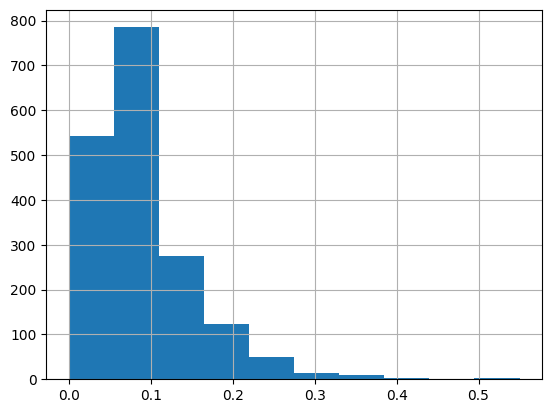

In [69]:

(top_rank_pnl_stats['sum(top_pnl_rotation)']/top_rank_pnl_stats['top_pnl_symbol_count']).rolling(1).mean().hist()

In [19]:
ind_col = 'pct_change_vwap_first'
all_bars_df=all_bars_df.withColumn('vol_x_price_first',py_f.col(ind_col)*py_f.col('volume_first'))
sp500_daily=all_bars_df.where(py_f.col(f"symbol").isin(mdg.sp500)).groupby('date').agg(py_f.sum('vol_x_price_first').alias('vol_x_price_sum'),
                                                                                       py_f.sum('volume_first').alias('volume_first_sum'),
                                                                                       (py_f.sum('vol_x_price_first')/py_f.sum('volume_first')).alias('pct_change_first_vwap')
                                                                                      )
bench=all_bars_df.where(py_f.col(f"symbol").isin('SPY')).groupby('date').agg(py_f.sum('pct_change_eod').alias('pct_change_eod'))
all_bars_df.show(1)
sp500_daily.show(1,truncate=False)
bench.show(1)
sp500_bench=sp500_daily.join(bench,on=['date']).withColumn('first_bar_dir',(py_f.col('pct_change_first_vwap')>0).cast('integer')*(py_f.col('pct_change_first_vwap')!=0).cast('integer') +(py_f.col('pct_change_first_vwap')<0).cast('integer')*(py_f.col('pct_change_first_vwap')!=0).cast('integer')*-1 ).\
                                                withColumn('eod_dir',(py_f.col('pct_change_eod')>0).cast('integer')*(py_f.col('pct_change_eod')!=0).cast('integer') +(py_f.col('pct_change_eod')<0).cast('integer')*(py_f.col('pct_change_eod')!=0).cast('integer')*-1 ).\
                                                withColumn('pnl',(py_f.col('first_bar_dir')==py_f.col('eod_dir')).cast("integer")*py_f.abs(py_f.col('pct_change_eod')) + (py_f.col('first_bar_dir')!=py_f.col('eod_dir')).cast("integer")*py_f.abs(py_f.col('pct_change_eod'))*-1)
sp500_bench.show(5)

+----------+------+-------------------+----------+-----------+------------+----------+--------------------+---------------------+-------------------+---------+----------+-----------+---------+--------------------+--------------------+--------------------+-------------------+------------------+---------+------------+---------+-----------------+-------------+--------+-----------------+
|      date|symbol|timestamp_utc_first|open_first|close_first|volume_first|vwap_first|    pct_change_first|pct_change_vwap_first| timestamp_utc_last|open_last|close_last|volume_last|vwap_last|     pct_change_last|pct_change_vwap_last|      pct_change_eod|first_bar_direction|      notional_pos|count_pos|notional_neg|count_neg|    neg_leg_multi|neutral_multi|pos_size|vol_x_price_first|
+----------+------+-------------------+----------+-----------+------------+----------+--------------------+---------------------+-------------------+---------+----------+-----------+---------+--------------------+-------------

In [20]:
#sp500_const_vs_bench = sp500_bench.toPandas().set_index('date').sort_index()
sp500_const_vs_bench.plot.scatter(x='pct_change_first_vwap',y='pnl')

NameError: name 'sp500_const_vs_bench' is not defined

                  pnl  pos_count
dir_first                       
-1        -111.282498     324686
 1          59.473435     322703


<AxesSubplot:xlabel='date'>

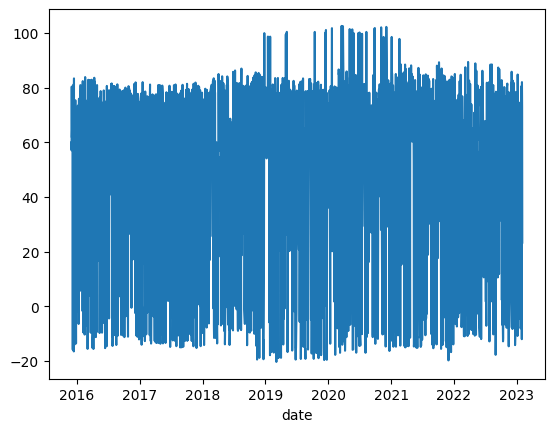

In [21]:
daily_pnl=first_last_df.groupBy('date','dir_first').agg(py_f.sum(f'pnl_{pnl_suffix}').alias('pnl'),py_f.count(f'pnl_{pnl_suffix}').alias('pos_count')).toPandas().set_index('date')
print(
daily_pnl.groupby('dir_first').sum(),
)
daily_pnl.query('dir_first==1').cumsum().pnl.plot()

In [22]:
print(daily_pnl[daily_pnl['pnl']<-0])
one_day_sample_pd=first_last_df.where('date=="2022-02-24"').toPandas()
one_day_sample_pd['notional']=one_day_sample_pd['close_first']*one_day_sample_pd['neutral_multi']
one_day_sample_pd.sort_values(f'pnl_{pnl_suffix}')

            dir_first       pnl  pos_count
date                                      
2015-12-30          1 -2.230187        296
2016-02-04         -1 -0.505633        248
2016-08-23          1 -0.247976         78
2016-10-24         -1 -0.038030         38
2016-11-14         -1 -0.691236        303
...               ...       ...        ...
2022-09-30          1 -4.368384        241
2022-10-28         -1 -0.921364         77
2022-10-31          1 -0.015607        130
2023-01-04         -1 -0.462555        181
2023-01-10         -1 -2.503498        286

[1820 rows x 3 columns]


,date,symbol,timestamp_utc_first,open_first,close_first,volume_first,vwap_first,pct_change_first,pct_change_vwap_first,timestamp_utc_last,...,notional_neg,count_neg,neg_leg_multi,neutral_multi,pos_size,dir_first,dir_eod,confusion_ind_eod,pnl_eod,notional
324,2022-02-24,DISH,2022-02-24 14:30:00,26.50,26.4400,836815.0,26.228890,-0.002264,-0.010231,2022-02-24 20:30:00,...,475735.1376,187,0.11655,0.11655,1,-1,1,-1,-0.114599,3.081593
417,2022-02-24,DAPP,2022-02-24 14:30:00,12.00,12.2144,39431.0,11.831070,0.017867,-0.014077,2022-02-24 20:30:00,...,475735.1376,187,0.11655,0.11655,1,-1,1,-1,-0.097066,1.423594
73,2022-02-24,HEI,2022-02-24 14:30:00,134.15,133.4800,51724.0,132.665251,-0.004994,-0.011068,2022-02-24 20:30:00,...,475735.1376,187,0.11655,0.11655,1,-1,1,-1,-0.060159,15.557151
34,2022-02-24,ZBRA,2022-02-24 14:30:00,389.72,392.4400,44514.0,389.116570,0.006979,-0.001548,2022-02-24 20:30:00,...,475735.1376,187,0.11655,0.11655,1,-1,1,-1,-0.058327,45.739049
57,2022-02-24,EQIX,2022-02-24 14:30:00,667.97,668.6300,47084.0,666.348128,0.000988,-0.002428,2022-02-24 20:30:00,...,475735.1376,187,0.11655,0.11655,1,-1,1,-1,-0.055756,77.929111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,2022-02-24,BTCM,2022-02-24 14:30:00,2.43,2.5600,58962.0,2.467900,0.053498,0.015597,2022-02-24 20:30:00,...,475735.1376,187,0.11655,1.00000,1,1,1,1,0.121094,2.560000
191,2022-02-24,MSTR,2022-02-24 14:30:00,340.24,353.4400,125043.0,345.230990,0.038796,0.014669,2022-02-24 20:30:00,...,475735.1376,187,0.11655,1.00000,1,1,1,1,0.121676,353.440000
422,2022-02-24,BITF,2022-02-24 14:30:00,2.80,2.9694,1485302.0,2.853743,0.060500,0.019194,2022-02-24 20:30:00,...,475735.1376,187,0.11655,1.00000,1,1,1,1,0.141645,2.969400
194,2022-02-24,SEDG,2022-02-24 14:30:00,223.83,237.0200,177718.0,231.049513,0.058929,0.032254,2022-02-24 20:30:00,...,475735.1376,187,0.11655,1.00000,1,1,1,1,0.143617,237.020000


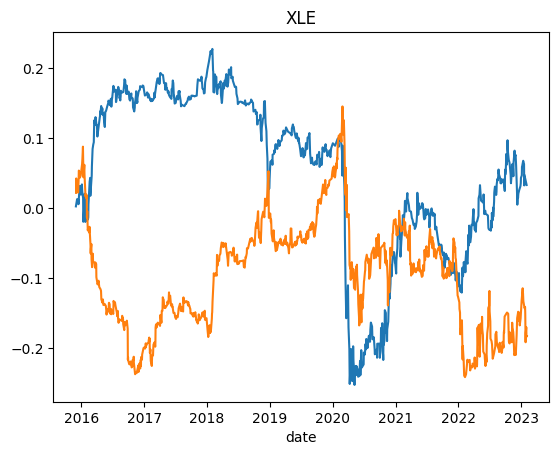

In [23]:
#daily_pnl['pnl'].cumsum().plot()
for one_symbol in ['XLE']:
    first_last_df.where(f'symbol=="{one_symbol}" and dir_first==1').toPandas().set_index('date').sort_index().pnl_eod.cumsum().plot(title=f"{one_symbol}")
    first_last_df.where(f'symbol=="{one_symbol}" and dir_first==-1').toPandas().set_index('date').sort_index().pnl_eod.cumsum().plot()

In [24]:
print(519849.0295/11333.2406)
one_day_sample_pd.groupby(['dir_first']).agg({'close_first':['sum'],'close_first':['sum'],'notional':['sum'],'pnl_eod':['sum','count']})

45.8694073343859


close_first    notional    pnl_eod      
                   sum         sum        sum count
dir_first                                          
-1         475735.1376  55447.1325  -2.878850   187
 1          55447.1325  55447.1325  11.976282   316

In [25]:
if False:
    suffix=''
else:
    suffix='_vs_bench'
study_col=f'pnl{suffix}'
bench_col=f'eod_pct_change{suffix}'



#perf_stat = get_perf_stats(one_sym_pd)

if False:
    perf_stats_df=first_last_df.where(py_f.col(f"symbol").isin(mdg.sp500)).groupBy('symbol').applyInPandas(lambda x: get_perf_stats(x,study_col), schema=panda_udf_schema )
    first_last_df.where(py_f.col(f"symbol").isin(mdg.sp500)).agg(py_f.mean(py_f.col('close')),py_f.max(py_f.col('close'))).show()
else:
    perf_stats_df=first_last_df.groupBy('symbol').applyInPandas(lambda x: get_perf_stats(x,study_col), schema=panda_udf_schema )
    first_last_df.agg(py_f.mean(py_f.col('close_last')),py_f.max(py_f.col('close_last'))).show()

+------------------+---------------+
|   avg(close_last)|max(close_last)|
+------------------+---------------+
|511.74834710027596|       525777.0|
+------------------+---------------+



In [26]:

perf_stats_pd = perf_stats_df.toPandas()
perf_stats_pd.sort_values('sharpe_ratio_strat').style

/usr/lib/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:201: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true, but has reached the error below and can not continue. Note that 'spark.sql.execution.arrow.pyspark.fallback.enabled' does not have an effect on failures in the middle of computation.
  An error occurred while calling o1201.getResult.
: org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:97)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:93)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Me

Py4JJavaError: An error occurred while calling o1201.getResult.
: org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:97)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:93)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 16 in stage 364.0 failed 4 times, most recent failure: Lost task 16.3 in stage 364.0 (TID 4206) (10.0.114.255 executor 24): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/tmp/ipykernel_91/3679669481.py", line 16, in <lambda>
  File "/tmp/ipykernel_91/3775025187.py", line 72, in get_perf_stats
  File "/usr/local/lib64/python3.7/site-packages/pandas/core/frame.py", line 3458, in __getitem__
    indexer = self.columns.get_loc(key)
  File "/usr/local/lib64/python3.7/site-packages/pandas/core/indexes/base.py", line 3363, in get_loc
    raise KeyError(key) from err
KeyError: 'pnl_pnl_vs_bench'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:559)
	at org.apache.spark.sql.execution.python.PythonArrowOutput$$anon$1.read(PythonArrowOutput.scala:101)
	at org.apache.spark.sql.execution.python.PythonArrowOutput$$anon$1.read(PythonArrowOutput.scala:50)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage21.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:35)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage21.hasNext(Unknown Source)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:968)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$$anon$1.hasNext(ArrowConverters.scala:99)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$$anon$1.foreach(ArrowConverters.scala:97)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$$anon$1.to(ArrowConverters.scala:97)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$$anon$1.toBuffer(ArrowConverters.scala:97)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$$anon$1.toArray(ArrowConverters.scala:97)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$6(Dataset.scala:3868)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2323)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:138)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1516)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2863)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2799)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2798)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2798)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1239)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1239)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1239)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3051)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2993)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:1009)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2229)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2324)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$5(Dataset.scala:3866)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1516)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$2(Dataset.scala:3870)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$2$adapted(Dataset.scala:3847)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:3922)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:552)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3920)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:107)
	at org.apache.spark.sql.execution.SQLExecution$.withTracker(SQLExecution.scala:224)
	at org.apache.spark.sql.execution.SQLExecution$.executeQuery$1(SQLExecution.scala:114)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$7(SQLExecution.scala:139)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:107)
	at org.apache.spark.sql.execution.SQLExecution$.withTracker(SQLExecution.scala:224)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:139)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:245)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:138)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:68)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3920)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$1(Dataset.scala:3847)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$1$adapted(Dataset.scala:3846)
	at org.apache.spark.security.SocketAuthServer$.$anonfun$serveToStream$2(SocketAuthServer.scala:139)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1516)
	at org.apache.spark.security.SocketAuthServer$.$anonfun$serveToStream$1(SocketAuthServer.scala:141)
	at org.apache.spark.security.SocketAuthServer$.$anonfun$serveToStream$1$adapted(SocketAuthServer.scala:136)
	at org.apache.spark.security.SocketFuncServer.handleConnection(SocketAuthServer.scala:113)
	at org.apache.spark.security.SocketFuncServer.handleConnection(SocketAuthServer.scala:107)
	at org.apache.spark.security.SocketAuthServer$$anon$1.$anonfun$run$4(SocketAuthServer.scala:68)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:68)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/tmp/ipykernel_91/3679669481.py", line 16, in <lambda>
  File "/tmp/ipykernel_91/3775025187.py", line 72, in get_perf_stats
  File "/usr/local/lib64/python3.7/site-packages/pandas/core/frame.py", line 3458, in __getitem__
    indexer = self.columns.get_loc(key)
  File "/usr/local/lib64/python3.7/site-packages/pandas/core/indexes/base.py", line 3363, in get_loc
    raise KeyError(key) from err
KeyError: 'pnl_pnl_vs_bench'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:559)
	at org.apache.spark.sql.execution.python.PythonArrowOutput$$anon$1.read(PythonArrowOutput.scala:101)
	at org.apache.spark.sql.execution.python.PythonArrowOutput$$anon$1.read(PythonArrowOutput.scala:50)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage21.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:35)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage21.hasNext(Unknown Source)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:968)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$$anon$1.hasNext(ArrowConverters.scala:99)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$$anon$1.foreach(ArrowConverters.scala:97)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$$anon$1.to(ArrowConverters.scala:97)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$$anon$1.toBuffer(ArrowConverters.scala:97)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$$anon$1.toArray(ArrowConverters.scala:97)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$6(Dataset.scala:3868)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2323)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:138)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1516)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)


In [ ]:
#perf_stats_df.show()

In [ ]:
fig_x,fig_y=8,2
perf_stats_pd.query(f'annual_return_strat>-10000 and annual_return_strat<10000')[['sharpe_ratio_buyhold','sharpe_ratio_strat']].hist(bins=10,figsize=(fig_x,fig_y))
perf_stats_pd.query(f'annual_return_strat>-10000 and annual_return_strat<10000')[['max_drawdown_buyhold','max_drawdown_strat']].hist(bins=10,figsize=(fig_x,fig_y))
(perf_stats_pd.query(f'annual_return_strat>-10000 and annual_return_strat<10000')[['annual_return_buyhold','annual_return_strat']]*1).hist(bins=10,figsize=(fig_x,fig_y))

In [ ]:
perf_stats_pd.query(f'annual_return_strat>=-10000')[['symbol','annual_return_strat']].sort_values(['annual_return_strat']).style

In [ ]:
themes=[i for i in vars(mdg) if ('_symbols' in i and '_df' not in i) or ('sectors' in i) or ('sp500' in i)]
pandas_res_dict={}
for one_theme in themes:
    one_theme_df = first_last_df.where(py_f.col("symbol").isin(getattr(mdg,one_theme)))
    one_theme_pd = (one_theme_df.groupBy('date').agg(py_f.mean(py_f.col('pnl_last')).alias('daily_pnl'))).toPandas()
    print(f"{one_theme}: {one_theme_pd['daily_pnl'].sum()}")
    pandas_res_dict[one_theme]=one_theme_pd
    one_theme_pd.set_index('date').sort_index().cumsum().plot(title=f'{one_theme}')


In [ ]:
symbol_subset=getattr(mdg,'fx_etf_symbols')+getattr(mdg,'crypto_mining_symbols')+getattr(mdg,'commod_etf_symbols')
one_theme_df=first_last_df.where(py_f.col("symbol").isin(symbol_subset))
one_theme_pd = (one_theme_df.groupBy('date').agg(py_f.mean(py_f.col('pnl_last')).alias('daily_pnl'))).toPandas()
pandas_res_dict[one_theme]=one_theme_pd
one_theme_pd.set_index('date').sort_index().cumsum().plot(title=f'--')


In [ ]:
plot_col = ['daily_pnl','daily_pnl_buy_hold']
res_stats.set_index('date').sort_index()[plot_col].plot()#.cumsum().plot()
(((res_stats.set_index('date').sort_index()[plot_col]).cumsum())).plot()

In [ ]:
plot_col = 'pct_right'
res_stats.set_index('date').sort_index()[[plot_col]].plot()#.cumsum().plot()
res_stats.set_index('date').sort_index()[[plot_col]].cumsum().plot()

In [18]:
[i for i in vars(mdg)]
#perf_stats_pd.query(f'annual_return_strat>0.10').sort_values('symbol')['symbol'].array

['shard_size',
 'fx_etf_symbols',
 'bitcoin_etf_symbols',
 'bitcoin_equity_proxy_symbols',
 'crypto_mining_symbols',
 'commod_etf_symbols',
 'fi_etf_symbols',
 'equity_share_class_pairs',
 'equity_etf_symbols',
 'sectors',
 'sp500',
 'bench_symbol',
 'all_symbols',
 'all_symbols_df',
 'columns_to_capture',
 'type_excl_field_map',
 'pandas_udf_schema',
 'data_folder',
 'parquet_file_out',
 'iex_token',
 'iex_ver',
 'iex_base_url',
 'old_df',
 'highwatermark_pd']

In [19]:
symbols_to_graph =perf_stats_pd.query(f'annual_return_strat>0.1 and annual_return_strat<.5').sort_values('symbol')['symbol'].array  
for one_sym in symbols_to_graph:#in mdg.sp500:
    one_sym_pd = first_last_df.where(f"symbol=='{one_sym}'").toPandas().set_index('date').sort_index()
    if False:
        one_sym_pd[[study_col,'eod_pct_change']].rolling(30*12).sum().plot(title=f'{one_sym}',figsize=(3,1.5))
    else:
        ((one_sym_pd[[study_col,'eod_pct_change']]+1).cumprod()-1).plot(title=f'{one_sym}',figsize=(3,1.5))


NameError: name 'perf_stats_pd' is not defined

In [ ]:
import vectorbt as vbt

one_day_pd = study_df.where("date == '2022-08-01'").toPandas().set_index('timestamp_utc').sort_index()
one_day_pd

,open,high,low,close,volume,trade_count,vwap,date,minute,symbol,is_last_bar,is_first_bar,is_random_check_bar,is_bench
timestamp_utc,,,,,,,,,,,,,,
2022-08-01 04:00:00,161.60,161.60,161.60,161.6000,120.0,1.0,161.600000,2022-08-01,04:00,AAPL,0,0,0,0
2022-08-01 04:00:00,278.83,278.83,278.83,278.8300,128.0,5.0,278.830000,2022-08-01,04:00,MSFT,0,0,0,0
2022-08-01 04:00:00,181.00,181.00,181.00,181.0000,174.0,1.0,181.000000,2022-08-01,04:00,NVDA,0,0,0,0
2022-08-01 04:00:00,94.70,94.70,94.70,94.7000,1500.0,2.0,94.700000,2022-08-01,04:00,AMD,0,0,0,0
2022-08-01 04:30:00,180.00,181.00,180.00,181.0000,317.0,7.0,180.410095,2022-08-01,04:30,NVDA,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01 23:30:00,45.78,45.78,45.70,45.7400,6863.0,45.0,45.737983,2022-08-01,23:30,ARKK,0,0,0,0
2022-08-01 23:30:00,184.61,184.80,184.45,184.7999,16948.0,240.0,184.617269,2022-08-01,23:30,NVDA,0,0,0,0
2022-08-01 23:30:00,124.00,124.00,123.65,123.6500,2488.0,14.0,123.910784,2022-08-01,23:30,ANET,0,0,0,0


In [ ]:
def backtest_one_day(l_pd):
    l_pd['open_close_pct_change']=(l_pd['close']/l_pd['open'])-1
    l_pd = pd.pivot_table(l_pd,values=['close','open_close_pct_change'], index=['timestamp_utc','is_last_bar','is_first_bar'],columns=['symbol']).ffill()
    return(l_pd)

ret_pd =backtest_one_day(one_day_pd)
long_entry_pd = ((ret_pd.query('is_first_bar==1')>0)*1)
short_entry_pd = ((ret_pd.query('is_first_bar==1')<0)*-1)
exit_pd=((ret_pd.query('is_last_bar==1'))['close']==(ret_pd.query('is_last_bar==1'))['close'])
price_pd = ret_pd['close'].reset_index().drop(columns=['is_last_bar','is_first_bar']).set_index('timestamp_utc').sort_index()
price_pd.tail(3)

symbol,A,AAL,AAP,AAPL,AAXJ,ABBV,ABC,ABT,ACGL,ACN,...,XOM,XOP,XRAY,XSD,XYL,YUM,ZBH,ZBRA,ZION,ZTS
timestamp_utc,,,,,,,,,,,,,,,,,,,,,
2022-08-01 22:30:00,133.43,14.22,195.99,161.4600,67.41,140.49,145.93,109.52,43.49,304.74,...,94.40,134.02,35.98,181.9,91.2,123.5,109.76,358.43,53.93,179.74
2022-08-01 23:00:00,133.80,14.23,195.99,161.4201,67.41,140.22,145.93,109.30,43.49,304.74,...,94.40,134.02,35.98,181.9,91.2,123.5,109.76,358.43,53.93,179.74
2022-08-01 23:30:00,133.80,14.22,195.99,161.4000,67.41,140.22,145.93,109.30,43.49,304.74,...,94.56,133.70,35.98,181.9,91.2,123.5,109.76,358.43,53.93,179.74


In [ ]:
fast_ma = vbt.MA.run(price_pd, 10, short_name='fast MA')
slow_ma = vbt.MA.run(price_pd, 50, short_name='fast MA')
long_entries = fast_ma.ma_crossed_above(slow_ma)
short_entries = fast_ma.ma_crossed_below(slow_ma)

pf = vbt.Portfolio.from_signals(
    price_pd,
    entries=long_entries,
    short_entries=short_entries, 
    freq = '1d'
)
pf.stats()

AssertionError: Type must be <class 'vectorbt.utils.decorators.CacheCondition'>, not <class 'collections.CacheCondition'>

In [ ]:
vbt._version

'0.23.3'

In [ ]:
import vectorbt as vbt
vbt.settings['caching']['enabled'] = False
data_folder="s3://fsidatalake/eod_market_data/etf_trend_following/"
one_sym='SPY'
spy_pd = spark.read.parquet(f"{data_folder}{one_sym}.parquet").toPandas().set_index('date').sort_index()['close']
spy_pd
 
aapl_close = spy_pd
#aapl_close.index=[(i.date()) for i in aapl_close.index]
fast_ma = vbt.MA.run(aapl_close, 10, short_name='fast MA')
slow_ma = vbt.MA.run(aapl_close, 50, short_name='fast MA')
long_entries = fast_ma.ma_crossed_above(slow_ma)
short_entries = fast_ma.ma_crossed_below(slow_ma)

pf = vbt.Portfolio.from_signals(
    aapl_close,
    entries=long_entries,
    short_entries=short_entries, 
    freq = '1d'
)
pf.stats()

AssertionError: Type must be <class 'vectorbt.utils.decorators.CacheCondition'>, not <class 'collections.CacheCondition'>

In [ ]:
price = pd.Series([1, 2, 3, 4, 5], dtype=int)
vbt.MA.run(price, [2, 3]).ma

AssertionError: Type must be <class 'vectorbt.utils.decorators.CacheCondition'>, not <class 'collections.CacheCondition'>

In [ ]:
print(datetime.date(2022, 12, 25))

2022-12-25


In [ ]:
sym_sample_pd['open_close'] = (
    (sym_sample_pd['close'] / sym_sample_pd['open'] - 1
    )) * 100  #+(sym_sample_pd['marketClose']/sym_sample_pd['marketOpen']-1))/2
bench_sym = 'SPY'
bench_pd = sym_sample_pd.query(f"symbol=='{bench_sym}'")
join_cols = ['timestamp', 'date', 'minute']
bench_pd.columns = [
    f'{i}_bench' if i not in join_cols else i for i in bench_pd.columns
]
sym_sample_pd_tmp = bench_pd.set_index(join_cols).join(
    sym_sample_pd.set_index(join_cols))
open_min='14:30'
close_min='20:30'
sym_sample_first_last = sym_sample_pd_tmp.query(
    f'minute=="{open_min}" or minute=="{close_min}"')

sym_pd_pivot = pd.pivot_table(sym_sample_first_last,
                              values=[
                                  'open_close', 'open', 'close',
                                  'open_close_bench', 'open_bench',
                                  'close_bench'
                              ],
                              index=['symbol', 'date'],
                              columns=['minute'],
                              aggfunc='mean').dropna()
sym_pd_pivot.columns = [i.replace(":","") for i in  sym_pd_pivot.columns.to_series().str.join('_')]
open_min=open_min.replace(":","")
close_min=close_min.replace(":","")
sym_pd_pivot['day_change'] = (
    (sym_pd_pivot[f'close_{close_min}'] / sym_pd_pivot[f'close_{open_min}'] - 1)) * 100
sym_pd_pivot['day_change_bench'] = (
    (sym_pd_pivot[f'close_bench_{close_min}'] / sym_pd_pivot[f'close_bench_{open_min}'] -
     1)) * 100

sym_pd_pivot['day_vs_bench_change'] = sym_pd_pivot['day_change'] - sym_pd_pivot[
    'day_change_bench']
sym_pd_pivot[f'open_close_vs_bench_{open_min}'] = sym_pd_pivot[
    f'open_close_{open_min}'] - sym_pd_pivot[f'open_close_bench_{open_min}']
sym_pd_pivot[f'open_close_vs_bench_{close_min}'] = sym_pd_pivot[
    f'open_close_{close_min}'] - sym_pd_pivot[f'open_close_bench_{close_min}']

sym_pd_pivot[f'open_close_{open_min}_SIGN'] = [
    1 if x > 0 else (0 if x == 0 else -1)
    for x in sym_pd_pivot[f'open_close_{open_min}']
]
sym_pd_pivot[f'open_close_{close_min}_SIGN'] = [
    1 if x > 0 else (0 if x == 0 else -1)
    for x in sym_pd_pivot[f'open_close_{close_min}']
]
sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN'] = [
    1 if x > 0 else (0 if x == 0 else -1)
    for x in sym_pd_pivot[f'open_close_vs_bench_{open_min}']
]
sym_pd_pivot[f'open_close_vs_bench_{close_min}_SIGN'] = [
    1 if x > 0 else (0 if x == 0 else -1)
    for x in sym_pd_pivot[f'open_close_vs_bench_{close_min}']
]
sym_pd_pivot['day_change_SIGN'] = [
    1 if x > 0 else (0 if x == 0 else -1) for x in sym_pd_pivot['day_change']
]
sym_pd_pivot['day_change_vs_bench_SIGN'] = [
    1 if x > 0 else (0 if x == 0 else -1)
    for x in sym_pd_pivot['day_vs_bench_change']
]

sym_pd_pivot['open_close_pnl']= ((sym_pd_pivot[f'open_close_{open_min}_SIGN']==sym_pd_pivot[f'open_close_{close_min}_SIGN'])*(sym_pd_pivot[f'open_close_{open_min}_SIGN']!=0))*abs(sym_pd_pivot[f'open_close_{close_min}'])+\
                                ((sym_pd_pivot[f'open_close_{open_min}_SIGN']!=sym_pd_pivot[f'open_close_{close_min}_SIGN'])*(sym_pd_pivot[f'open_close_{open_min}_SIGN']!=0))*abs(sym_pd_pivot[f'open_close_{close_min}'])*-1
sym_pd_pivot['day_change_pnl']= ((sym_pd_pivot[f'open_close_{open_min}_SIGN']==sym_pd_pivot['day_change_SIGN'])*(sym_pd_pivot[f'open_close_{open_min}_SIGN']!=0))*abs(sym_pd_pivot['day_change'])+\
                                ((sym_pd_pivot[f'open_close_{open_min}_SIGN']!=sym_pd_pivot['day_change_SIGN'])*(sym_pd_pivot[f'open_close_{open_min}_SIGN']!=0))*abs(sym_pd_pivot['day_change'])*-1
sym_pd_pivot['open_close_ind']= ((sym_pd_pivot[f'open_close_{open_min}_SIGN']==sym_pd_pivot[f'open_close_{close_min}_SIGN'])*(sym_pd_pivot[f'open_close_{open_min}_SIGN']!=0))+\
                                ((sym_pd_pivot[f'open_close_{open_min}_SIGN']!=sym_pd_pivot[f'open_close_{close_min}_SIGN'])*(sym_pd_pivot[f'open_close_{open_min}_SIGN']!=0))*-1
sym_pd_pivot['day_change_ind']= ((sym_pd_pivot[f'open_close_{open_min}_SIGN']==sym_pd_pivot['day_change_SIGN'])*(sym_pd_pivot[f'open_close_{open_min}_SIGN']!=0))+\
                                ((sym_pd_pivot[f'open_close_{open_min}_SIGN']!=sym_pd_pivot['day_change_SIGN'])*(sym_pd_pivot[f'open_close_{open_min}_SIGN']!=0))*-1

sym_pd_pivot['open_close_vs_bench_pnl']= ((sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']==sym_pd_pivot[f'open_close_vs_bench_{close_min}_SIGN'])*(sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=0))*abs(sym_pd_pivot[f'open_close_vs_bench_{close_min}'])+\
                                         ((sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=sym_pd_pivot[f'open_close_vs_bench_{close_min}_SIGN'])*(sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=0))*abs(sym_pd_pivot[f'open_close_vs_bench_{close_min}'])*-1
sym_pd_pivot['day_change_vs_bench_pnl']= ((sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']==sym_pd_pivot['day_change_vs_bench_SIGN'])*(sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=0))*abs(sym_pd_pivot['day_vs_bench_change'])+\
                                         ((sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=sym_pd_pivot['day_change_vs_bench_SIGN'])*(sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=0))*abs(sym_pd_pivot['day_vs_bench_change'])*-1
sym_pd_pivot['open_close_vs_bench_ind']= ((sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']==sym_pd_pivot[f'open_close_vs_bench_{close_min}_SIGN'])*(sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=0))+\
                                         ((sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=sym_pd_pivot[f'open_close_vs_bench_{close_min}_SIGN'])*(sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=0))*-1
sym_pd_pivot['day_change_vs_bench_ind']= ((sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']==sym_pd_pivot['day_change_vs_bench_SIGN'])*(sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=0))+\
                                         ((sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=sym_pd_pivot['day_change_vs_bench_SIGN'])*(sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=0))*-1

KeyError: "None of ['timestamp'] are in the columns"

In [ ]:
strat_stats = sym_pd_pivot.reset_index().groupby([
    'symbol', f'open_close_{open_min}_SIGN'
]).agg({
    'open_close_pnl': ['count', 'mean', 'sum'],
    'day_change_pnl': ['mean', 'sum'],
    'open_close_vs_bench_pnl':['mean','sum'],
    'day_change_vs_bench_pnl':['mean','sum'],
    #'open_close_vs_bench_ind': ['mean', 'sum'],
    #'day_change_vs_bench_ind': ['mean', 'sum'],
    #'open_close_ind': ['mean', 'sum'],
    #'day_change_ind': ['mean', 'sum'],
    'date': ['min', 'max']
})
strat_stats.columns = strat_stats.columns.to_series().str.join('_')
trade_dir=1
pnl_f='day_change_vs_bench_pnl'
pos_pd = strat_stats.query(f"open_close_pnl_count>200 & {pnl_f}_mean>0.01 & open_close_{open_min}_SIGN=={trade_dir}").sort_index()
pos_pd.style

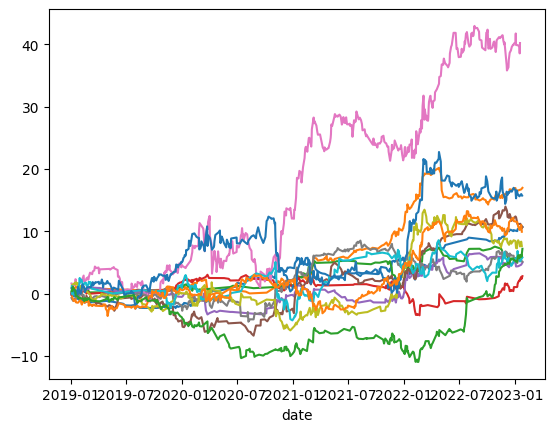

In [ ]:
res_check_arr= []

for symbol_check in pos_pd.reset_index().symbol:
    l_pd = sym_pd_pivot[sym_pd_pivot[f'open_close_{open_min}_SIGN'] == 1].query(
        f'symbol=="{symbol_check}"').reset_index().set_index('date')
    res_check_arr=res_check_arr+[l_pd[['symbol',pnl_f]]]
    l_pd[pnl_f].cumsum().plot()

#pf.create_returns_tear_sheet(l_pd['day_change_pnl']/ 100)

<AxesSubplot:xlabel='date'>

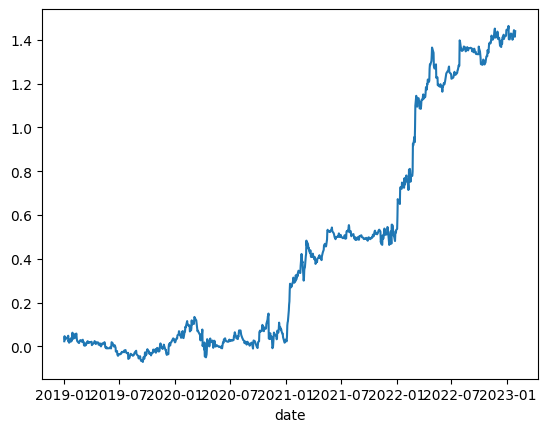

In [ ]:
portf_pnl=pd.pivot_table(pd.concat(res_check_arr), values=[ pnl_f ],
                              index=[ 'date'],
                              columns=['symbol'],
                              aggfunc='mean' )
portf_pnl['daily_pnl']=portf_pnl.sum(axis=1)/100
portf_pnl['daily_pnl'].cumsum().plot()

<AxesSubplot:xlabel='date'>

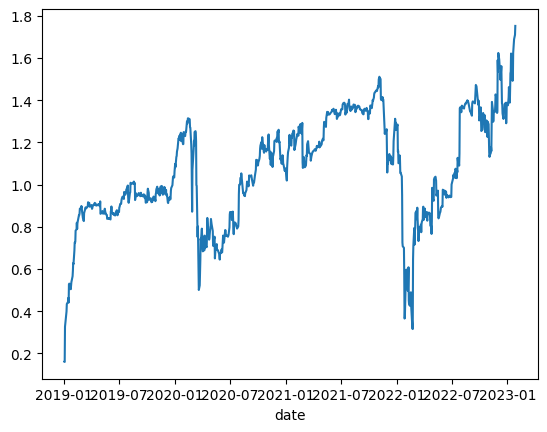

In [ ]:
portf_pnl=pd.pivot_table(pd.concat(res_check_arr), values=[ pnl_f ],
                              index=[ 'date'],
                              columns=['symbol'],
                              aggfunc='mean' )
portf_pnl['daily_pnl']=portf_pnl.sum(axis=1)/100
portf_pnl['daily_pnl'].cumsum().plot()

In [ ]:
data = vbt.YFData.download(
        'AAPL',
        interval = '1d'
    )

data_close = data.get('Close')
ma_fast = vbt.MA.run(data_close, 10)
ma_slow = vbt.MA.run(data_close, 50)
entries = ma_fast.ma_crossed_above(ma_slow)
exits   = ma_fast.ma_crossed_below(ma_slow)
res = vbt.Portfolio.from_signals(
    data_close,
    entries = entries,
    exits = exits,
    freq = 'd'
)

AssertionError: Type must be <class 'vectorbt.utils.decorators.CacheCondition'>, not <class 'collections.CacheCondition'>

In [3]:
spark.createDataFrame(data_close.to_frame(name='aapl_close')).coalesce(1).repartition(1).write\
                .option("header",True)\
                .mode("overwrite")\
                .parquet('s3://fsidatalake/intraday_market_data/aapl_sample_data.parquet')


NameError: name 'data_close' is not defined

In [12]:
study_config = {'first_bar':'14:30',
                'last_bar':'21:00',
               }
###
window_part=py_w.Window.partitionBy('symbol','date').orderBy('timestamp_utc')
window_cum=window_part.rowsBetween(py_w.Window.unboundedPreceding, 0)
window_prev=window_part
###
#mul_udf = F.udf(lambda x: reduce(mul, x), types.IntegerType())
###
study_df = spark.read.parquet(mdg.parquet_file_out).where(f'minute>="{study_config.get("first_bar")}" and minute<="{study_config.get("last_bar")}" ')
study_df =study_df.withColumn('is_last_bar',
                    py_f.when(py_f.col('minute')==py_f.lit(study_config.get('last_bar')),1).otherwise(py_f.lit(0))).\
        withColumn('is_first_bar',
                    py_f.when(py_f.col('minute')==py_f.lit(study_config.get('first_bar')),1).otherwise(py_f.lit(0))).\
        withColumn('pct_change_bar',py_f.col('close')/py_f.col('open')-1).\
        withColumn('pct_change_prev',py_f.col('close')/py_f.lag('close',1).over(window_prev) -1).\
        withColumn('pct_change_cumsum',py_f.sum('pct_change_prev').over(window_cum)).\
        withColumn('pct_change_cumsum',py_f.when(py_f.col("pct_change_cumsum").isNull(),0.0).otherwise(py_f.col("pct_change_cumsum")))

study_df.orderBy('symbol',py_f.col('timestamp_utc').desc()).show(3,truncate=False)
study_df_pivot_change=study_df.groupBy('timestamp_utc','date','is_last_bar','is_first_bar').pivot('symbol').sum('pct_change_cumsum')
final_bar_per_day = study_df.groupBy('date').agg(py_f.max('timestamp_utc').alias('final_day_bar'))
study_df_pivot_close=study_df.groupBy('timestamp_utc','date').pivot('symbol').sum('close').\
                                withColumnRenamed('SPY','SPY_close').\
                                withColumnRenamed('QQQ','QQQ_close').\
                                withColumnRenamed('ARKK','ARKK_close')
study_df_pivot=study_df_pivot_change.join(study_df_pivot_close,on=['timestamp_utc','date']).join(final_bar_per_day,on='date').\
                    withColumn('is_last_bar',py_f.when(py_f.col('final_day_bar')==py_f.col('timestamp_utc'),1).otherwise(py_f.col('is_last_bar')))
study_df_pivot.where("date=='2022-09-22'").show(3)
study_df_pivot.count()

+-------------------+------+------+-----+------+---------+-----------+---------+----------+------+------+-----------+------------+----------------------+----------------------+--------------------+
|timestamp_utc      |open  |high  |low  |close |volume   |trade_count|vwap     |date      |minute|symbol|is_last_bar|is_first_bar|pct_change_bar        |pct_change_prev       |pct_change_cumsum   |
+-------------------+------+------+-----+------+---------+-----------+---------+----------+------+------+-----------+------------+----------------------+----------------------+--------------------+
|2023-02-03 21:00:00|42.85 |42.85 |42.82|42.84 |2683329.0|28.0       |42.849834|2023-02-03|21:00 |ARKK  |1          |0           |-2.333722287047868E-4 |-1.166997315905638E-4 |0.017377670447326077|
|2023-02-03 20:59:00|42.86 |42.86 |42.83|42.845|346781.0 |1603.0     |42.847957|2023-02-03|20:59 |ARKK  |0          |0           |-3.4997666822211837E-4|-2.333450005833626E-4 |0.01749437017891664 |
|2023-02-0

704322

In [13]:
test_interp= study_df_pivot.where("date=='2022-09-22'").toPandas().set_index('timestamp_utc').sort_index()
test_interp['ARKK_close_interp']=test_interp['ARKK_close'].interpolate()
test_interp

,date,is_last_bar,is_first_bar,ARKK,QQQ,SPY,ARKK_close,QQQ_close,SPY_close,final_day_bar,ARKK_close_interp
timestamp_utc,,,,,,,,,,,
2022-09-22 14:30:00,2022-09-22,0,1,0.000000,0.000000,0.000000,39.2450,280.6000,375.2400,2022-09-22 21:00:00,39.2450
2022-09-22 14:31:00,2022-09-22,0,0,0.001656,0.000713,0.000400,39.3100,280.8000,375.3901,2022-09-22 21:00:00,39.3100
2022-09-22 14:32:00,2022-09-22,0,0,0.006490,0.002600,0.001812,39.5000,281.3300,375.9200,2022-09-22 21:00:00,39.5000
2022-09-22 14:33:00,2022-09-22,0,0,0.005728,0.002209,0.001289,39.4699,281.2200,375.7237,2022-09-22 21:00:00,39.4699
2022-09-22 14:34:00,2022-09-22,0,0,0.003450,0.000660,-0.000171,39.3800,280.7843,375.1750,2022-09-22 21:00:00,39.3800
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-22 20:56:00,2022-09-22,0,0,-0.016316,-0.001023,-0.001596,38.6000,280.2900,374.6200,2022-09-22 21:00:00,38.6000
2022-09-22 20:57:00,2022-09-22,0,0,NaN,-0.001094,-0.001649,NaN,280.2700,374.6000,2022-09-22 21:00:00,38.6050
2022-09-22 20:58:00,2022-09-22,0,0,-0.016057,-0.001237,-0.001943,38.6100,280.2300,374.4900,2022-09-22 21:00:00,38.6100


In [14]:
study_pd=study_df_pivot.toPandas()
data_stats=(study_pd.reset_index().groupby('date').apply(lambda x: (x.isna()*1).sum()).sum(axis=1)/2).to_frame(name='null_count')
study_pd=study_pd.set_index('date').join(data_stats).query('null_count<(387*0.5)').reset_index().set_index(['timestamp_utc']).sort_index().drop(columns=['final_day_bar','null_count'])
study_pd=study_pd.groupby('date').apply(lambda x: x.sort_index().interpolate()).dropna().reset_index().set_index(['timestamp_utc','date']).sort_index()
#.set_index(['timestamp_utc','date']).sort_index()#.interpolate().dropna()
study_pd[study_pd.index.get_level_values(1)==datetime.date(2022, 9, 22)]

,,is_last_bar,is_first_bar,ARKK,QQQ,SPY,ARKK_close,QQQ_close,SPY_close
timestamp_utc,date,,,,,,,,
2022-09-22 14:30:00,2022-09-22,0,1,0.000000,0.000000,0.000000,39.2450,280.6000,375.2400
2022-09-22 14:31:00,2022-09-22,0,0,0.001656,0.000713,0.000400,39.3100,280.8000,375.3901
2022-09-22 14:32:00,2022-09-22,0,0,0.006490,0.002600,0.001812,39.5000,281.3300,375.9200
2022-09-22 14:33:00,2022-09-22,0,0,0.005728,0.002209,0.001289,39.4699,281.2200,375.7237
2022-09-22 14:34:00,2022-09-22,0,0,0.003450,0.000660,-0.000171,39.3800,280.7843,375.1750
...,...,...,...,...,...,...,...,...,...
2022-09-22 20:56:00,2022-09-22,0,0,-0.016316,-0.001023,-0.001596,38.6000,280.2900,374.6200
2022-09-22 20:57:00,2022-09-22,0,0,-0.016186,-0.001094,-0.001649,38.6050,280.2700,374.6000
2022-09-22 20:58:00,2022-09-22,0,0,-0.016057,-0.001237,-0.001943,38.6100,280.2300,374.4900


In [15]:
study_pd['direction_checksum']=0
for one_pair in [['ARKK','QQQ'],['QQQ','SPY'],['ARKK','SPY']]:
    study_pd[f'{one_pair[0]}_{one_pair[1]}']=(study_pd[one_pair[0]]>study_pd[one_pair[1]])*1+(study_pd[one_pair[0]]==study_pd[one_pair[1]])*0+(study_pd[one_pair[0]]<study_pd[one_pair[1]])*-1
    study_pd[f'{one_pair[0]}_{one_pair[1]}_spread']=(study_pd[one_pair[0]]-study_pd[one_pair[1]])
    study_pd['direction_checksum']=study_pd['direction_checksum']+study_pd[f'{one_pair[0]}_{one_pair[1]}']
    study_pd[f'{one_pair[0]}_{one_pair[1]}_prev']=study_pd[f'{one_pair[0]}_{one_pair[1]}'].shift(1).fillna(0)
study_pd['direction_aligned'] = (study_pd['direction_checksum']==3)*1+(study_pd['direction_checksum']==-3)*-1
study_pd['ARKK_SPY_pnl'] = study_pd['direction_aligned'].abs() *study_pd['ARKK_SPY_spread'].abs()+study_pd['ARKK_SPY_spread']*-1 *(study_pd['direction_aligned']==0)
study_pd['minute'] = study_pd.index.get_level_values('timestamp_utc').strftime('%H:%M')
study_pd.groupby(['minute','direction_aligned']).agg({'ARKK_SPY_pnl':['mean','count']})
study_pd

,,is_last_bar,is_first_bar,ARKK,QQQ,SPY,ARKK_close,QQQ_close,SPY_close,direction_checksum,ARKK_QQQ,...,ARKK_QQQ_prev,QQQ_SPY,QQQ_SPY_spread,QQQ_SPY_prev,ARKK_SPY,ARKK_SPY_spread,ARKK_SPY_prev,direction_aligned,ARKK_SPY_pnl,minute
timestamp_utc,date,,,,,,,,,,,,,,,,,,,,,
2017-11-03 14:30:00,2017-11-03,0,1,0.000000,0.000000,0.000000,34.950000,152.1500,257.5957,0,0,...,0.0,0,0.000000,0.0,0,0.000000,0.0,0,0.000000,14:30
2017-11-03 14:31:00,2017-11-03,0,0,0.002861,-0.000357,-0.000216,35.050000,152.0957,257.5400,1,1,...,0.0,-1,-0.000141,0.0,1,0.003077,0.0,0,-0.003077,14:31
2017-11-03 14:32:00,2017-11-03,0,0,0.002099,-0.000460,-0.000488,35.023300,152.0800,257.4700,3,1,...,1.0,1,0.000028,-1.0,1,0.002587,1.0,1,0.002587,14:32
2017-11-03 14:33:00,2017-11-03,0,0,0.001933,-0.000657,-0.000449,35.017475,152.0500,257.4800,1,1,...,1.0,-1,-0.000208,1.0,1,0.002382,1.0,0,-0.002382,14:33
2017-11-03 14:34:00,2017-11-03,0,0,0.001767,-0.000329,-0.000372,35.011650,152.1000,257.5000,3,1,...,1.0,1,0.000043,-1.0,1,0.002138,1.0,1,0.002138,14:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-03 20:56:00,2023-02-03,0,0,0.018427,0.004542,0.001223,42.885000,306.6900,412.5800,3,1,...,1.0,1,0.003319,1.0,1,0.017205,1.0,1,0.017205,20:56
2023-02-03 20:57:00,2023-02-03,0,0,0.018078,0.003958,0.001005,42.870000,306.5109,412.4900,3,1,...,1.0,1,0.002954,1.0,1,0.017073,1.0,1,0.017073,20:57
2023-02-03 20:58:00,2023-02-03,0,0,0.017728,0.003822,0.000811,42.855000,306.4691,412.4101,3,1,...,1.0,1,0.003011,1.0,1,0.016917,1.0,1,0.016917,20:58


array([[<AxesSubplot:title={'center':'ARKK_SPY_spread'}>]], dtype=object)

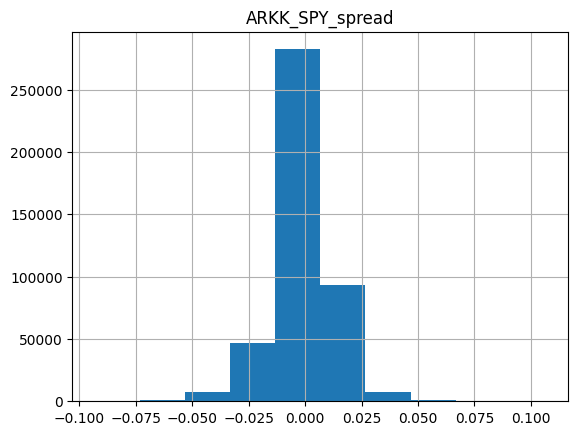

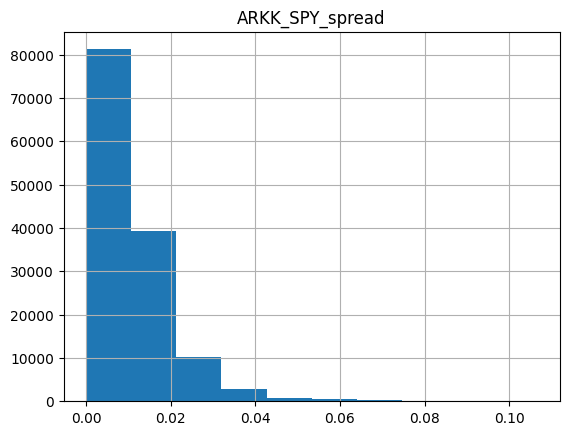

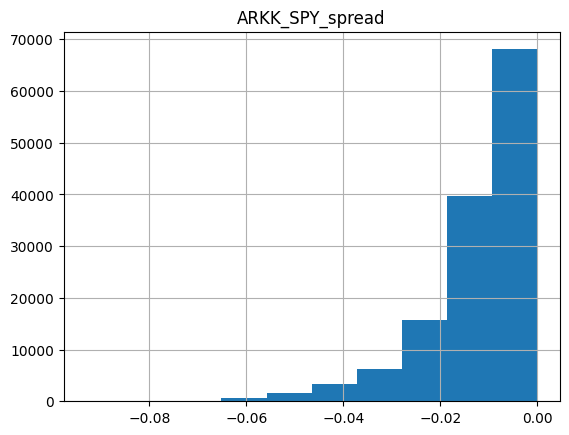

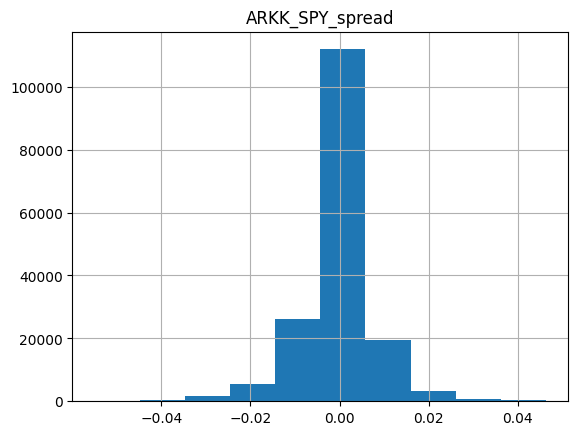

In [16]:
study_pd[['ARKK_SPY_spread']].hist()
study_pd.query('direction_aligned==1')[['ARKK_SPY_spread']].hist()
study_pd.query('direction_aligned==-1')[['ARKK_SPY_spread']].hist()
study_pd.query('direction_aligned==0')[['ARKK_SPY_spread']].hist()

In [17]:
#study_df_final.show()

In [30]:
import statsmodels.api as sm

@jit
def one_day_np(l_df):
    if True:
        def get_rmse(y,y_pred):
            return(np.sqrt((np.sum((y_pred-y)**2))/len(y)))
        def get_r2(y,y_pred):
            y_ypred_corr = np.corrcoef(y,y_pred)
            corr=y_ypred_corr[0,1]
            return(corr**2)

        is_last_raw=l_df[:,4]
        is_last=is_last_raw[len(is_last_raw)-1]
        if len(l_df)>1:
            x=l_df[:,0]
            y=l_df[:,1]
            b1=np.corrcoef(x,y)[0][1]*(np.std(y)/np.std(x))
            c=np.mean(y)-b1*np.mean(x)
            y_pred= c+b1*x
            rmse=get_rmse(y,y_pred)
            r2=get_r2(y,y_pred)
            
            ptiles=np.percentile(y_pred-y, [1,5,10,25,75,90,95,99]) 
            p1=ptiles[0]
            p5=ptiles[1]
            p10=ptiles[2]
            p25=ptiles[3]
            p75=ptiles[4]
            p90=ptiles[5]
            p95=ptiles[6]
            p99=ptiles[7]
        else:
            c,b1,rmse,r2,is_last,p1,p5,p10,p25,p75,p90,p95,p99=0,0,0,0,0,0,0,0,0,0,0,0,0
        ret_val=[c,b1,rmse,r2,is_last,p1,p5,p10,p25,p75,p90,p95,p99]
    else:
        ret_val=[0,0,0,0,0,0,0,0,0,0,0,0,0]
    return(ret_val)

def one_day_ols(l_df):
    from statsmodels.tools.eval_measures import rmse
    Y=np.array(l_df['ARKK_SPY_spread'].values)
    X=np.array(l_df['QQQ_SPY_spread'].values)
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    ret_dict={}
    ret_dict['r2'] = results.rsquared
    ret_dict['pval'] = (results.pvalues)
    ret_dict['coeff']=(results.params)
    ret_dict['date']=l_df.reset_index().date.max()
    ypred = results.predict(X)
    rmse = rmse(Y, ypred)
    ret_dict['rmse']=rmse
    return(ret_dict)
res=(one_day_ols(study_pd))
print(res)
@jit
def test(l_df):
    #print((l_df))
    return([0,0,0,0])

{'r2': 0.37517105116262217, 'pval': array([5.80543428e-160, 0.00000000e+000]), 'coeff': array([-4.22694782e-04,  2.32455870e+00]), 'date': datetime.date(2023, 2, 3), 'rmse': 0.010400905778211282}


In [19]:
study_pd.columns

Index(['is_last_bar', 'is_first_bar', 'ARKK', 'QQQ', 'SPY', 'ARKK_close',
       'QQQ_close', 'SPY_close', 'direction_checksum', 'ARKK_QQQ',
       'ARKK_QQQ_spread', 'ARKK_QQQ_prev', 'QQQ_SPY', 'QQQ_SPY_spread',
       'QQQ_SPY_prev', 'ARKK_SPY', 'ARKK_SPY_spread', 'ARKK_SPY_prev',
       'direction_aligned', 'ARKK_SPY_pnl', 'minute'],
      dtype='object')

In [20]:
if False:
    #study_pd['datetime']=study_pd.reset_index()['date'].apply(lambda x: np.datetime64(x))
    #study_pd.reset_index().set_index('timestamp_utc').sort_index().rolling('5D',axis=0)[['QQQ_SPY_spread','ARKK_SPY_spread']].apply(test,raw=True)
    linreg_res = study_pd.reset_index().set_index('timestamp_utc').sort_index().rolling('5D',method='table',min_periods=1)\
                    [['QQQ_SPY_spread','ARKK_SPY_spread','QQQ','ARKK','is_last_bar',
                      'SPY','ARKK_SPY_pnl','direction_aligned','ARKK_SPY_prev','ARKK_SPY','QQQ_SPY_prev','QQQ_SPY','ARKK_QQQ_prev']]\
                                          .apply(one_day_np, raw=True,engine='numba').query('is_last_bar==1')
    linreg_res.columns=['const','coeff','rmse','r2','is_last_bar','p1','p5','p10','p25','p75','p90','p95','p99']
    linreg_res['date_model']=linreg_res.index.date
    linreg_res['date_price']=linreg_res[['date_model']].shift(-1,freq='D')
    linreg_res=linreg_res.reset_index().rename(columns={'date_price':'date'}).set_index('date').drop(columns=['timestamp_utc']).drop_duplicates()
    linreg_res

In [21]:
if False:
    study_pd_with_model=study_pd.reset_index().set_index('date').join(linreg_res.drop(columns=['is_last_bar']),how='left').fillna(method='ffill').sort_index()
    study_pd_with_model['ARKK_SPY_model']=study_pd_with_model['const']*0+study_pd_with_model['coeff']*study_pd_with_model['QQQ_SPY_spread']
    study_pd_with_model['ARKK_SPY_model_vs_actual']=study_pd_with_model['ARKK_SPY_model']-study_pd_with_model['ARKK_SPY_spread']
    study_pd_with_model['ARKK_SPY_model_vs_actual_align']=(study_pd_with_model['ARKK_SPY_model']>0)*(study_pd_with_model['ARKK_SPY_spread']>0)*1+\
                                                          (study_pd_with_model['ARKK_SPY_model']<0)*(study_pd_with_model['ARKK_SPY_spread']<0)*-1
else:
    study_pd_with_model=study_pd.copy(deep=True)
    study_pd_with_model['zero']=0
    (study_pd_with_model)

In [22]:
study_pd_with_model[['ARKK_rank','QQQ_rank','SPY_rank']]=study_pd_with_model[['ARKK','QQQ','SPY']].rank(axis=1)
for i in ['ARKK_rank','QQQ_rank','SPY_rank']:
    study_pd_with_model[f'{i}_prev']=study_pd_with_model[f'{i}'].shift(1).fillna(0)

In [23]:
study_pd_with_model

,,is_last_bar,is_first_bar,ARKK,QQQ,SPY,ARKK_close,QQQ_close,SPY_close,direction_checksum,ARKK_QQQ,...,direction_aligned,ARKK_SPY_pnl,minute,zero,ARKK_rank,QQQ_rank,SPY_rank,ARKK_rank_prev,QQQ_rank_prev,SPY_rank_prev
timestamp_utc,date,,,,,,,,,,,,,,,,,,,,,
2017-11-03 14:30:00,2017-11-03,0,1,0.000000,0.000000,0.000000,34.950000,152.1500,257.5957,0,0,...,0,0.000000,14:30,0,2.0,2.0,2.0,0.0,0.0,0.0
2017-11-03 14:31:00,2017-11-03,0,0,0.002861,-0.000357,-0.000216,35.050000,152.0957,257.5400,1,1,...,0,-0.003077,14:31,0,3.0,1.0,2.0,2.0,2.0,2.0
2017-11-03 14:32:00,2017-11-03,0,0,0.002099,-0.000460,-0.000488,35.023300,152.0800,257.4700,3,1,...,1,0.002587,14:32,0,3.0,2.0,1.0,3.0,1.0,2.0
2017-11-03 14:33:00,2017-11-03,0,0,0.001933,-0.000657,-0.000449,35.017475,152.0500,257.4800,1,1,...,0,-0.002382,14:33,0,3.0,1.0,2.0,3.0,2.0,1.0
2017-11-03 14:34:00,2017-11-03,0,0,0.001767,-0.000329,-0.000372,35.011650,152.1000,257.5000,3,1,...,1,0.002138,14:34,0,3.0,2.0,1.0,3.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-03 20:56:00,2023-02-03,0,0,0.018427,0.004542,0.001223,42.885000,306.6900,412.5800,3,1,...,1,0.017205,20:56,0,3.0,2.0,1.0,3.0,2.0,1.0
2023-02-03 20:57:00,2023-02-03,0,0,0.018078,0.003958,0.001005,42.870000,306.5109,412.4900,3,1,...,1,0.017073,20:57,0,3.0,2.0,1.0,3.0,2.0,1.0
2023-02-03 20:58:00,2023-02-03,0,0,0.017728,0.003822,0.000811,42.855000,306.4691,412.4101,3,1,...,1,0.016917,20:58,0,3.0,2.0,1.0,3.0,2.0,1.0


In [24]:
if False:
    y,m,d=2022,11,25
    one_date=datetime.date(y,m,d)
    for one_date in [i for i in set(study_pd_with_model.index.get_level_values(0)) if i.year==y and i.month==m and i.day==d]:
        params=str(study_pd_with_model[study_pd_with_model.index==one_date].reset_index()[['zero']].drop_duplicates())
        fs=(10,6)
        plot_pd= study_pd_with_model[study_pd_with_model.index==one_date].reset_index().set_index('timestamp_utc')
        plot_pd[['ARKK','QQQ','SPY','ARKK_SPY_spread','zero']].drop_duplicates().plot(figsize=fs,title=params)
        #plot_pd[['ARKK_SPY_model_vs_actual','ARKK_SPY_model','ARKK_SPY_spread','zero']].drop_duplicates().plot(figsize=fs,title=params)
        #plot_pd[['QQQ_SPY_spread','ARKK_SPY_spread','zero']].drop_duplica11es().plot(figsize=fs,title=params)

<AxesSubplot:xlabel='QQQ_SPY_spread', ylabel='ARKK_SPY_spread'>

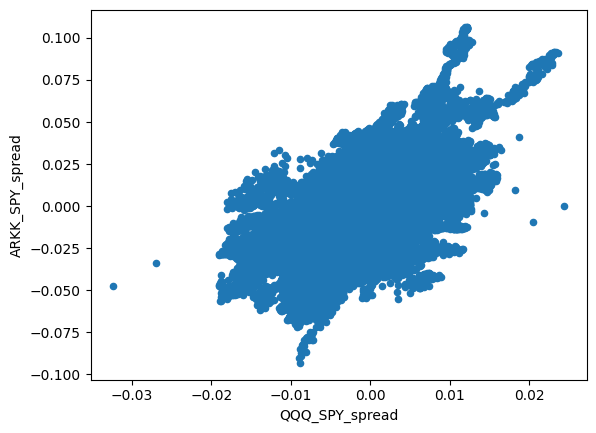

In [25]:
study_pd.plot.scatter(x='QQQ_SPY_spread',y='ARKK_SPY_spread')

In [26]:
study_pd_with_model.reset_index().columns

Index(['timestamp_utc', 'date', 'is_last_bar', 'is_first_bar', 'ARKK', 'QQQ',
       'SPY', 'ARKK_close', 'QQQ_close', 'SPY_close', 'direction_checksum',
       'ARKK_QQQ', 'ARKK_QQQ_spread', 'ARKK_QQQ_prev', 'QQQ_SPY',
       'QQQ_SPY_spread', 'QQQ_SPY_prev', 'ARKK_SPY', 'ARKK_SPY_spread',
       'ARKK_SPY_prev', 'direction_aligned', 'ARKK_SPY_pnl', 'minute', 'zero',
       'ARKK_rank', 'QQQ_rank', 'SPY_rank', 'ARKK_rank_prev', 'QQQ_rank_prev',
       'SPY_rank_prev'],
      dtype='object')

In [29]:
if False:
    study_df_final=spark.createDataFrame(study_pd_with_model.reset_index())
    (
      study_df_final.where("ARKK is Null").groupBy("date").count().show(3),
      study_df_final.where("SPY is Null").groupBy("date").count().show(3),
      study_df_final.where("QQQ is Null").groupBy("date").count().show(3)
     )
    if False:
        study_df_final.coalesce(1).repartition(1).write\
                        .option("header",True)\
                        .mode("overwrite")\
                        .parquet('s3://fsidatalake/intraday_market_data/arkk_spy_qqq.parquet')
    study_pd_with_model.groupby(['ARKK_QQQ','QQQ_SPY','ARKK_SPY']).count().style
else:
    study_pd

In [ ]:
study_pd[['ARKK','is_last_bar','']].head(1000)

In [42]:
True | True

True

In [62]:
one_day_pd=study_pd[study_pd.index.get_level_values(1)==datetime.date(2022, 9, 22)]
for i in ['ARKK','QQQ','SPY']:
    one_day_pd[f"{i}_cumprod"]=(one_day_pd[f"{i}_close"].pct_change().fillna(0)+1).cumprod()-1
one_day_pd.tail(50)

/usr/local/bin/kernel-launchers/python/scripts/launch_ipykernel.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import json


,,is_last_bar,is_first_bar,ARKK,QQQ,SPY,ARKK_close,QQQ_close,SPY_close,ARKK_cumprod,QQQ_cumprod,SPY_cumprod
timestamp_utc,date,,,,,,,,,,,
2022-09-22 20:11:00,2022-09-22,0,0,-0.014784,-0.000810,-0.001223,38.66000,280.35,374.76,-0.014906,-0.000891,-0.001279
2022-09-22 20:12:00,2022-09-22,0,0,-0.016078,-0.001025,-0.001383,38.61000,280.29,374.70,-0.016180,-0.001105,-0.001439
2022-09-22 20:13:00,2022-09-22,0,0,-0.014265,-0.000810,-0.001117,38.68000,280.35,374.80,-0.014397,-0.000891,-0.001173
2022-09-22 20:14:00,2022-09-22,0,0,-0.014911,-0.001203,-0.001730,38.65500,280.24,374.57,-0.015034,-0.001283,-0.001786
2022-09-22 20:15:00,2022-09-22,0,0,-0.015557,-0.001809,-0.001971,38.63000,280.07,374.48,-0.015671,-0.001889,-0.002025
2022-09-22 20:16:00,2022-09-22,0,0,-0.015816,-0.001559,-0.001730,38.62000,280.14,374.57,-0.015926,-0.001639,-0.001786
2022-09-22 20:17:00,2022-09-22,0,0,-0.016075,-0.001524,-0.001570,38.61000,280.15,374.63,-0.016180,-0.001604,-0.001626
2022-09-22 20:18:00,2022-09-22,0,0,-0.016075,-0.001881,-0.001970,38.61000,280.05,374.48,-0.016180,-0.001960,-0.002025
2022-09-22 20:19:00,2022-09-22,0,0,-0.016075,-0.001809,-0.001970,38.61000,280.07,374.48,-0.016180,-0.001889,-0.002025


<AxesSubplot:xlabel='timestamp_utc,date'>

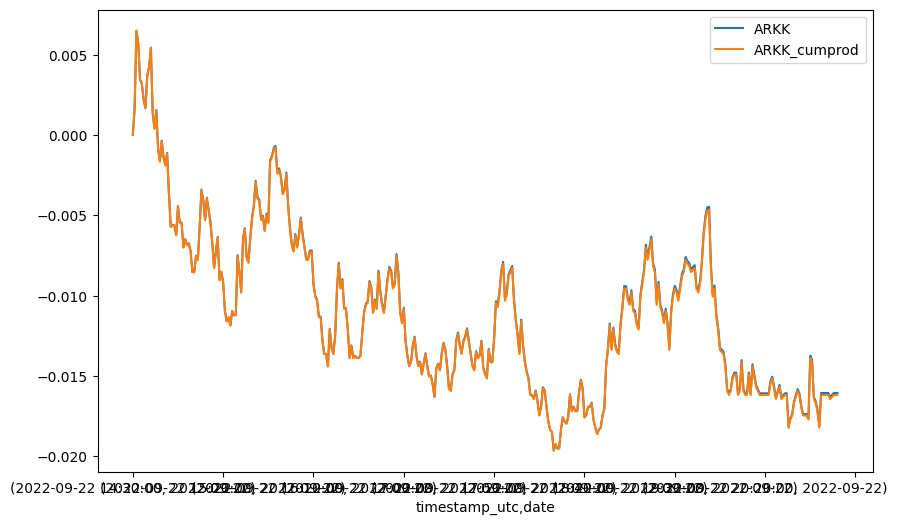

In [63]:
(one_day_pd[['ARKK','ARKK_cumprod']]*1).plot(figsize=(10,6))

<AxesSubplot:xlabel='timestamp_utc,date'>

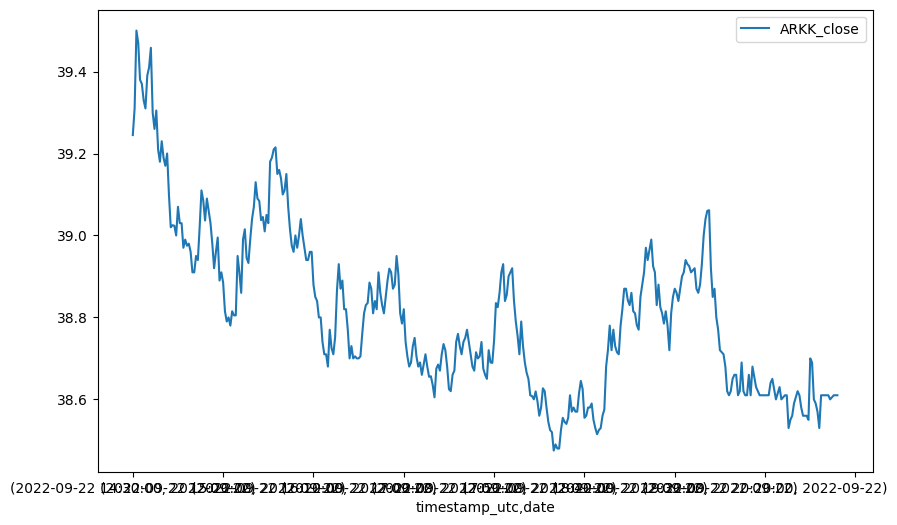

In [64]:
(one_day_pd[['ARKK_close']]*1).plot(figsize=(10,6))

In [27]:
study_pd_daily =study_pd_with_model.reset_index().groupby('date')[['ARKK','QQQ','SPY']].sum()
study_pd_daily['is_aligned']=(((study_pd_daily['QQQ']>study_pd_daily['SPY'])&(study_pd_daily['ARKK']>study_pd_daily['QQQ'])) + \
                             ((study_pd_daily['QQQ']<study_pd_daily['SPY'])&(study_pd_daily['ARKK']<study_pd_daily['QQQ'])))*(1)
study_pd_daily['is_aligned_prev']=study_pd_daily['is_aligned'].shift(1)
study_pd_daily['occ_start_date']=np.where(study_pd_daily['is_aligned']==study_pd_daily['is_aligned_prev'],None,study_pd_daily.reset_index().date)
study_pd_daily['occ_start_date']=study_pd_daily['occ_start_date'].fillna(method='ffill')
study_pd_daily.groupby('is_aligned').count()

,ARKK,QQQ,SPY,is_aligned_prev,occ_start_date
is_aligned,,,,,
0,421,421,421,421,421
1,706,706,706,705,706


In [32]:
align_stats=study_pd_daily.groupby(['is_aligned','occ_start_date']).count()[['QQQ']].reset_index()
align_stats.head(3)

,is_aligned,occ_start_date,QQQ
0,0,2017-11-09,1
1,0,2017-11-17,2
2,0,2017-11-27,2


<AxesSubplot:>

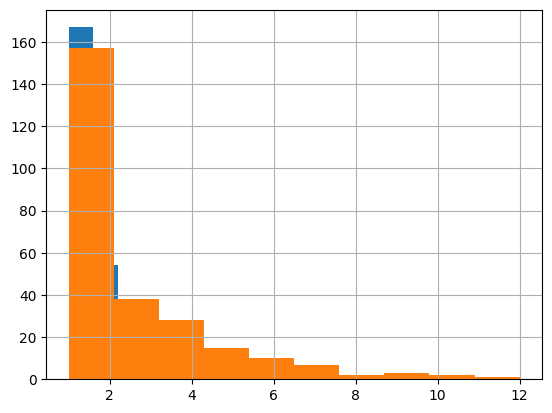

In [33]:
align_stats.query('is_aligned==0')['QQQ'].hist()
align_stats.query('is_aligned==1')['QQQ'].hist()

In [31]:
def one_day_ols(l_df):
    from statsmodels.tools.eval_measures import rmse
    Y=np.array(l_df['ARKK_SPY_spread'].values)
    X=np.array(l_df['QQQ_SPY_spread'].values)
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    ret_dict={}
    ret_dict['r2'] = results.rsquared
    ret_dict['pval'] = (results.pvalues)
    ret_dict['coeff']=(results.params)
    ret_dict['end_date']=l_df.reset_index().date.max()
    ret_dict['start_date']=l_df.reset_index().date.max()
    ypred = results.predict(X)
    rmse = rmse(Y, ypred)
    ret_dict['rmse']=rmse
    return(ret_dict)


In [36]:
study_pd_daily['ARKK_SPY_spread']=study_pd_daily['ARKK']-study_pd_daily['SPY']
study_pd_daily['QQQ_SPY_spread']=study_pd_daily['QQQ']-study_pd_daily['SPY']
res=(one_day_ols(study_pd_daily))
res

{'r2': 0.3758748225432863,
 'pval': array([1.32158686e-001, 2.68188915e-117]),
 'coeff': array([-0.16456366,  2.3564691 ]),
 'date': datetime.date(2023, 2, 3),
 'rmse': 3.6629624980109545}